# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
import copy

alpha, beta, gamma = 0.24, 1.4, 1/5.1

# Functions

In [3]:
def calculate_ca(days,grid,data):
    ca = np.zeros((days, grid.shape[0], grid.shape[1]))
    region_population = regions[['ID', 'Cell Count']].set_index('ID').to_dict()[
        'Cell Count']
    for i in range(days):
        col_name = data.columns[i+4]
        region_cases = data[['Province/State', col_name]
                                ].set_index('Province/State').to_dict()[col_name]
        for j in range(grid.shape[0]):
            for k in range(grid.shape[1]):
                if grid[j, k] != 0:
                    region_id = grid[j, k]
                    cell_count = region_population[region_id]
                    region_name = regions.loc[regions['ID']
                                              == region_id, 'Region'].iloc[0]
                    cases = 0
                    if ',' in region_name:
                        region_list = region_name.split(',')
                        for sub_region in region_list:
                            sub_region = sub_region.strip()
                            cases += region_cases.get(sub_region, 0)
                    else:
                        cases = region_cases.get(region_name, 0)
                    ca[i, j, k] = cases / cell_count
    return ca

def fix_p(p):
    one,center,north,east,south,west=range(6)
    rows, cols = p.shape[0], p.shape[1]
    for i in range(rows):
        for j in range(cols):
            if grid[i,j] == 0:
                p[i,j] = 0
            else:
                if i == 0:
                    p[i,j,north] = 0
                elif i == rows - 1:
                    p[i,j,south] = 0
                if j == 0:
                    p[i,j,west] = 0
                elif j == cols - 1:
                    p[i,j,east] = 0
                if i > 0 and grid[i-1,j] == 0:
                    p[i,j,north] = 0
                if j < cols - 1 and grid[i,j+1] == 0:
                    p[i,j,east] = 0
                if i < rows - 1 and grid[i+1,j] == 0:
                    p[i,j,south] = 0
                if j > 0 and grid[i,j-1] == 0:
                    p[i,j,west] = 0
    return p

def calculate_p(ca_infected):
    p = np.zeros((len(ca_infected) - 1, grid.shape[0], grid.shape[1], 6))
    for i in range(1, len(ca_infected)):
        current_day = ca_infected[i - 1]
        north = np.zeros_like(current_day)
        north[1:] = current_day[:-1]
        south = np.zeros_like(current_day)
        south[:-1] = current_day[1:]
        east = np.zeros_like(current_day)
        east[:, :-1] = current_day[:, 1:]
        west = np.zeros_like(current_day)
        west[:, 1:] = current_day[:, :-1]
        current_cell = np.stack(
            [np.ones_like(current_day), current_day, north, east, south, west], axis=-1)
        p[i - 1] = np.concatenate((current_cell[..., :1],
                                  current_cell[..., 1:] * (beta - gamma - alpha)), axis=-1)
    for i in range(p.shape[0]):
        p[i]=fix_p(p[i])
    return p

In [4]:
def predict_i(p, q):
    N, M, _ = p.shape
    delta_i = np.zeros((N, M))
    for j in range(N):
        for k in range(M):
            delta_i[j, k] = np.dot(p[j, k], q[j, k])
    return delta_i

def find_q(delta_i, p):
    t, N, M = delta_i.shape
    q = np.zeros((N, M, 6))
    for j in range(N):
        for k in range(M):
            if grid[j,k]!=0:
                delta_i_jk = delta_i[:,j,k]
                p_jk = p[:,j,k,:]
                model = sklearn.linear_model.LinearRegression().fit(p_jk, delta_i_jk)
                q[j, k, :] = model.coef_
                q[j,k,0]=model.intercept_
    return q

In [5]:
def calculate_m_bar(m):
    unique_values = np.unique(grid)
    m_bar = np.zeros_like(m)
    for value in unique_values:
        indices = np.where(grid == value)
        cell_count = len(indices[0])
        m_sum = round(np.sum(m[indices]))
        if m_sum<0.:
            m_sum=0.
        m_bar[grid == value] = m_sum / cell_count
    return m_bar

def calculate_m(m_bar,p_bar,q):
    return m_bar+predict_i(p_bar,q)

def calculate_p_bar(m_bar):
    north = np.zeros_like(m_bar)
    north[1:] = m_bar[:-1]
    south = np.zeros_like(m_bar)
    south[:-1] = m_bar[1:]
    east = np.zeros_like(m_bar)
    east[:, :-1] = m_bar[:, 1:]
    west = np.zeros_like(m_bar)
    west[:, 1:] = m_bar[:, :-1]
    aux = np.stack(
    [np.ones_like(m_bar),m_bar,north,east,south,west],axis=-1)
    new_p=np.concatenate((aux[...,:1],
                         aux[...,1:]*(beta-gamma-alpha)),axis=-1)
    return fix_p(new_p)

In [6]:
def draw_map(grid,width,height):
    df = pd.DataFrame(grid)

    cmap = sns.diverging_palette(0, 250, as_cmap=True)
    color_map = cmap.from_list("", [(0, "lightblue"), (1, "white")], N=2)

    f, ax = plt.subplots(figsize=(width, height))
    plt.pcolormesh(df, cmap=color_map, vmin=0, vmax=1)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            horizontal = j < df.shape[1] - 1 and df.iloc[i, j] != df.iloc[i, j + 1]
            vertical = i < df.shape[0] - 1 and df.iloc[i, j] != df.iloc[i + 1, j]

            if horizontal:
                plt.plot([j + 1, j + 1], [i, i + 1], color="black", linewidth=3)
            elif j < df.shape[1] - 1:
                plt.plot([j + 1, j + 1], [i, i + 1], color="gray", linewidth=1)

            if vertical:
                plt.plot([j, j + 1], [i + 1, i + 1], color="black", linewidth=3)
            elif i < df.shape[0] - 1:
                plt.plot([j, j + 1], [i + 1, i + 1], color="gray", linewidth=1)

    plt.gca().invert_yaxis()
    plt.show()

In [10]:
def draw_borders(ax, grid):
    n, m = grid.shape
    for j in range(n):
        for k in range(m):
            horizontal = k < m - 1 and grid[j, k] != grid[j, k + 1]
            vertical = j < n - 1 and grid[j, k] != grid[j + 1, k]

            if horizontal:
                ax.plot([k + 1, k + 1], [j, j + 1], color="black", linewidth=3)
            elif k < m - 1:
                ax.plot([k + 1, k + 1], [j, j + 1], color="gray", linewidth=1)

            if vertical:
                ax.plot([k, k + 1], [j + 1, j + 1], color="black", linewidth=3)
            elif j < n - 1:
                ax.plot([k, k + 1], [j + 1, j + 1], color="gray", linewidth=1)

def draw_color_map(grid, ca_infected, number_of_weeks, width, height):
    color_grid = copy.deepcopy(ca_infected)
    for i in range(ca_infected.shape[0]):
        aux = color_grid[i]
        aux[np.where(grid == 0)] = -2
        color_grid[i] = aux

    boundaries = [-2, -1, 0.02127659574468084, 2, 25, 100, 500, 501]
    values = ['lightblue', 'white', 'lime', 'yellow', 'orange', 'darkorange', 'red']
    cmap = plt.matplotlib.colors.ListedColormap(values)
    norm = plt.matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

    fig, axs = plt.subplots(number_of_weeks, 7, figsize=(width, height), sharex=True, sharey=True)
    cols = ['Day {}'.format(day + 1) for day in range(7)]
    rows = ['Week {}'.format(week + 1) for week in range(number_of_weeks)]

    for i, ax in enumerate(axs.flatten()):
        if i < 7 * number_of_weeks:
            ax.pcolormesh(color_grid[i, :, :], cmap=cmap, norm=norm, shading='flat')
            ax.set_ylim(color_grid[i, :, :].shape[0], 0)
            draw_borders(ax, grid)
        else:
            ax.axis('off')

        ax.set_xticks([])
        ax.set_yticks([])

    for ax, col in zip(axs[0], cols):
        ax.set_title(col)

    for ax, row in zip(axs[:, 0], rows):
        ax.set_ylabel(row, rotation=0, size='large', ha='right')

    plt.show()

# China

In [8]:
grid = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 14, 14, 10, 10, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 27, 27, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 14, 14, 14, 14, 10, 10, 10, 10],
    [0, 0, 0, 0, 0, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 14, 14, 14, 14, 10, 10, 10, 10],
    [0, 0, 0, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0,
        0, 0, 14, 14, 14, 14, 14, 14, 17, 17, 10, 10],
    [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0,
        0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 17, 17, 17],
    [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 5, 5, 14, 14,
        14, 14, 14, 14, 14, 14, 2, 2, 18, 18, 18, 0, 0],
    [27, 27, 27, 27, 27, 27, 27, 27, 27, 20, 20, 5, 5,
        5, 5, 14, 14, 24, 24, 2, 2, 2, 2, 18, 0, 0, 0],
    [0, 27, 27, 27, 27, 26, 26, 26, 20, 20, 20, 20, 20,
        20, 5, 5, 19, 21, 24, 24, 22, 22, 22, 22, 0, 0, 0],
    [0, 26, 26, 26, 26, 26, 26, 26, 20, 20, 20, 20, 20,
        5, 5, 5, 21, 21, 11, 11, 11, 1, 1, 15, 0, 0, 0],
    [0, 26, 26, 26, 26, 26, 26, 26, 26, 26, 20, 20, 20,
        20, 5, 21, 21, 25, 12, 12, 11, 16, 1, 15, 0, 0, 0],
    [0, 0, 0, 26, 26, 26, 26, 26, 26, 26, 26, 20, 20, 20,
        25, 25, 25, 25, 12, 12, 12, 16, 23, 23, 0, 0, 0],
    [0, 0, 0, 0, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25,
        25, 3, 3, 8, 13, 13, 16, 16, 4, 23, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 25, 25,
        25, 8, 8, 8, 13, 13, 13, 4, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 25, 28,
        28, 28, 7, 7, 7, 7, 6, 6, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28, 28,
        28, 7, 7, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]
])
days = 6*7
prediction_days=2*7
final_df = pd.read_csv('data/china/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))
final_df= final_df[final_df['Country/Region']=='China']

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/china/regions.csv')

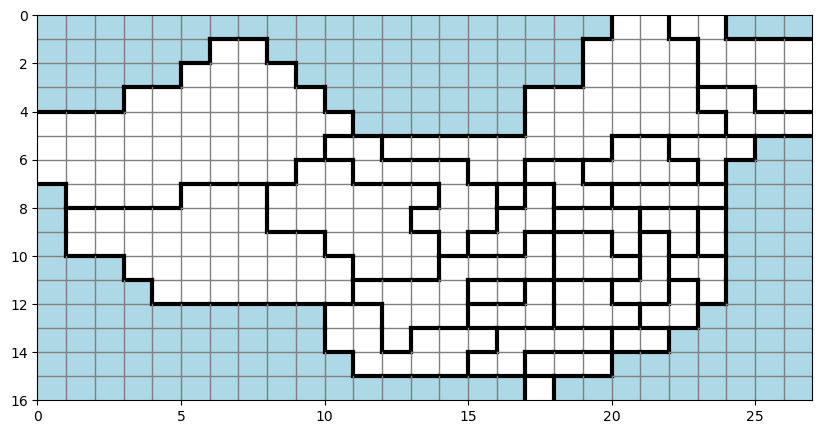

In [9]:
draw_map(grid,10,5)

In [11]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

In [ ]:
draw_color_map(grid,ca_infected,6,20,15)

In [33]:
q = find_q(delta_I, p)

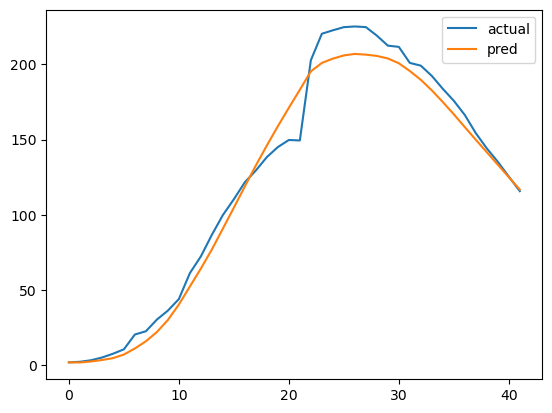

In [34]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

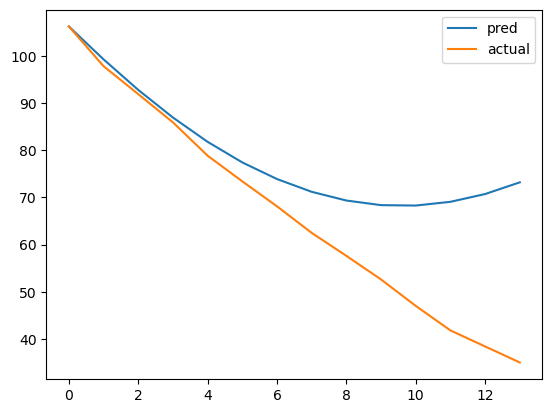

In [37]:
actual=calculate_ca(prediction_days,grid,test_infected)
m=actual[0]
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    p_bar=calculate_p_bar(m_bar)
    m=calculate_m(m_bar,p_bar,q)
prediction[-1]=calculate_m_bar(m) 
pred_sums=[prediction[i].sum()/258 for i in range(prediction_days)]
actual_sums=[actual[i].sum()/258 for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

In [38]:
actual=calculate_ca(prediction_days,grid,test_infected)
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))

p=calculate_p(actual)

m=actual[0]
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
    print("Pred:",m.sum())
    print("Actual:",actual[i].sum())
prediction[-1]=calculate_m_bar(m) 

Pred: 25600.609147019226
Actual: 25230.0
Pred: 23838.283280823158
Actual: 23702.0
Pred: 22052.033621917577
Actual: 22159.0
Pred: 20298.554996935283
Actual: 20335.0
Pred: 18673.971044543978
Actual: 18933.0
Pred: 17198.47664121528
Actual: 17567.0
Pred: 15746.415836355129
Actual: 16116.0
Pred: 14358.032696101067
Actual: 14859.0
Pred: 13014.153597203456
Actual: 13568.999999999998
Pred: 11767.382009912553
Actual: 12123.999999999998
Pred: 10597.449588006544
Actual: 10783.0
Pred: 9539.83550187351
Actual: 9906.0
Pred: 8594.109081839204
Actual: 9030.000000000002


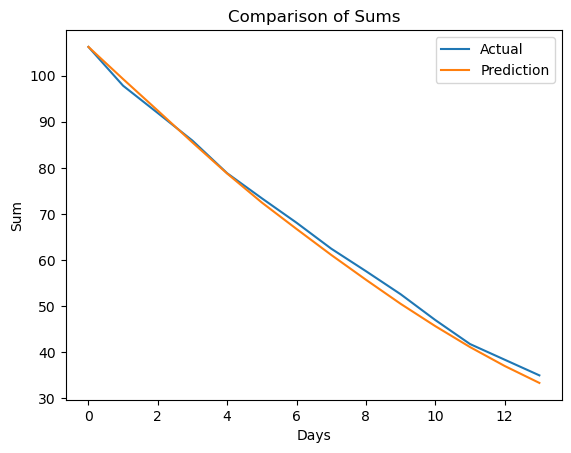

In [39]:
prediction_sums = [prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums = [actual[i].sum()/total_cells for i in range(prediction_days)]

plt.plot(range(prediction_days), actual_sums, label="Actual")
plt.plot(range(prediction_days), prediction_sums, label="Prediction")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sum")
plt.title("Comparison of Sums")
plt.show()

In [ ]:
draw_color_map(grid,actual,2,20,4)

In [ ]:
draw_color_map(grid,prediction,2,20,4)

# Belgium

In [14]:
grid = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,11,11,0,0,0,0,0,3,1,1,1,1,1,1,0,0,0,0,0,0,0],
    [0,0,11,11,11,11,3,3,3,3,3,3,1,1,1,1,1,1,7,7,7,0,0,0,0],
    [0,11,11,11,11,11,3,3,3,3,3,1,1,1,1,1,1,7,7,7,7,7,0,0,0],
    [0,11,11,11,11,11,11,3,3,3,3,4,4,4,4,4,4,7,7,7,7,0,0,0,0],
    [0,11,11,11,11,11,11,3,3,3,3,4,2,4,4,4,4,7,7,7,7,0,0,0,0],
    [0,0,11,5,0,5,5,5,5,5,4,4,10,10,10,10,6,6,6,6,6,6,6,6,0],
    [0,0,0,0,0,5,5,5,5,5,5,5,10,10,9,9,9,6,6,6,6,6,6,6,0],
    [0,0,0,0,0,0,0,0,5,5,5,5,5,5,9,9,9,9,6,6,6,6,6,6,6],
    [0,0,0,0,0,0,0,0,5,5,5,5,5,9,9,9,9,9,9,8,8,6,8,6,6],
    [0,0,0,0,0,0,0,0,0,0,0,5,5,9,9,9,9,9,8,8,8,8,8,6,0],
    [0,0,0,0,0,0,0,0,0,0,0,5,5,9,0,9,8,8,8,8,8,8,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,5,5,9,0,9,9,8,8,8,8,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,8,8,8,8,8,8,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,8,8,8,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,8,0,0,0]
])
days = 8*7
prediction_days=2*7

final_df = pd.read_csv('data//belgium/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))
final_df= final_df[final_df['Country/Region']=='Belgium']

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/belgium/regions.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/time_series_covid19_active_global.csv'

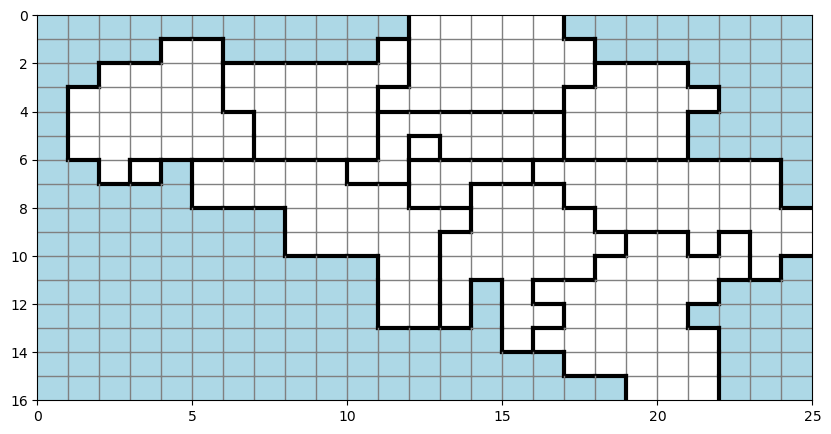

In [21]:
draw_map(grid,10,5)

In [22]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

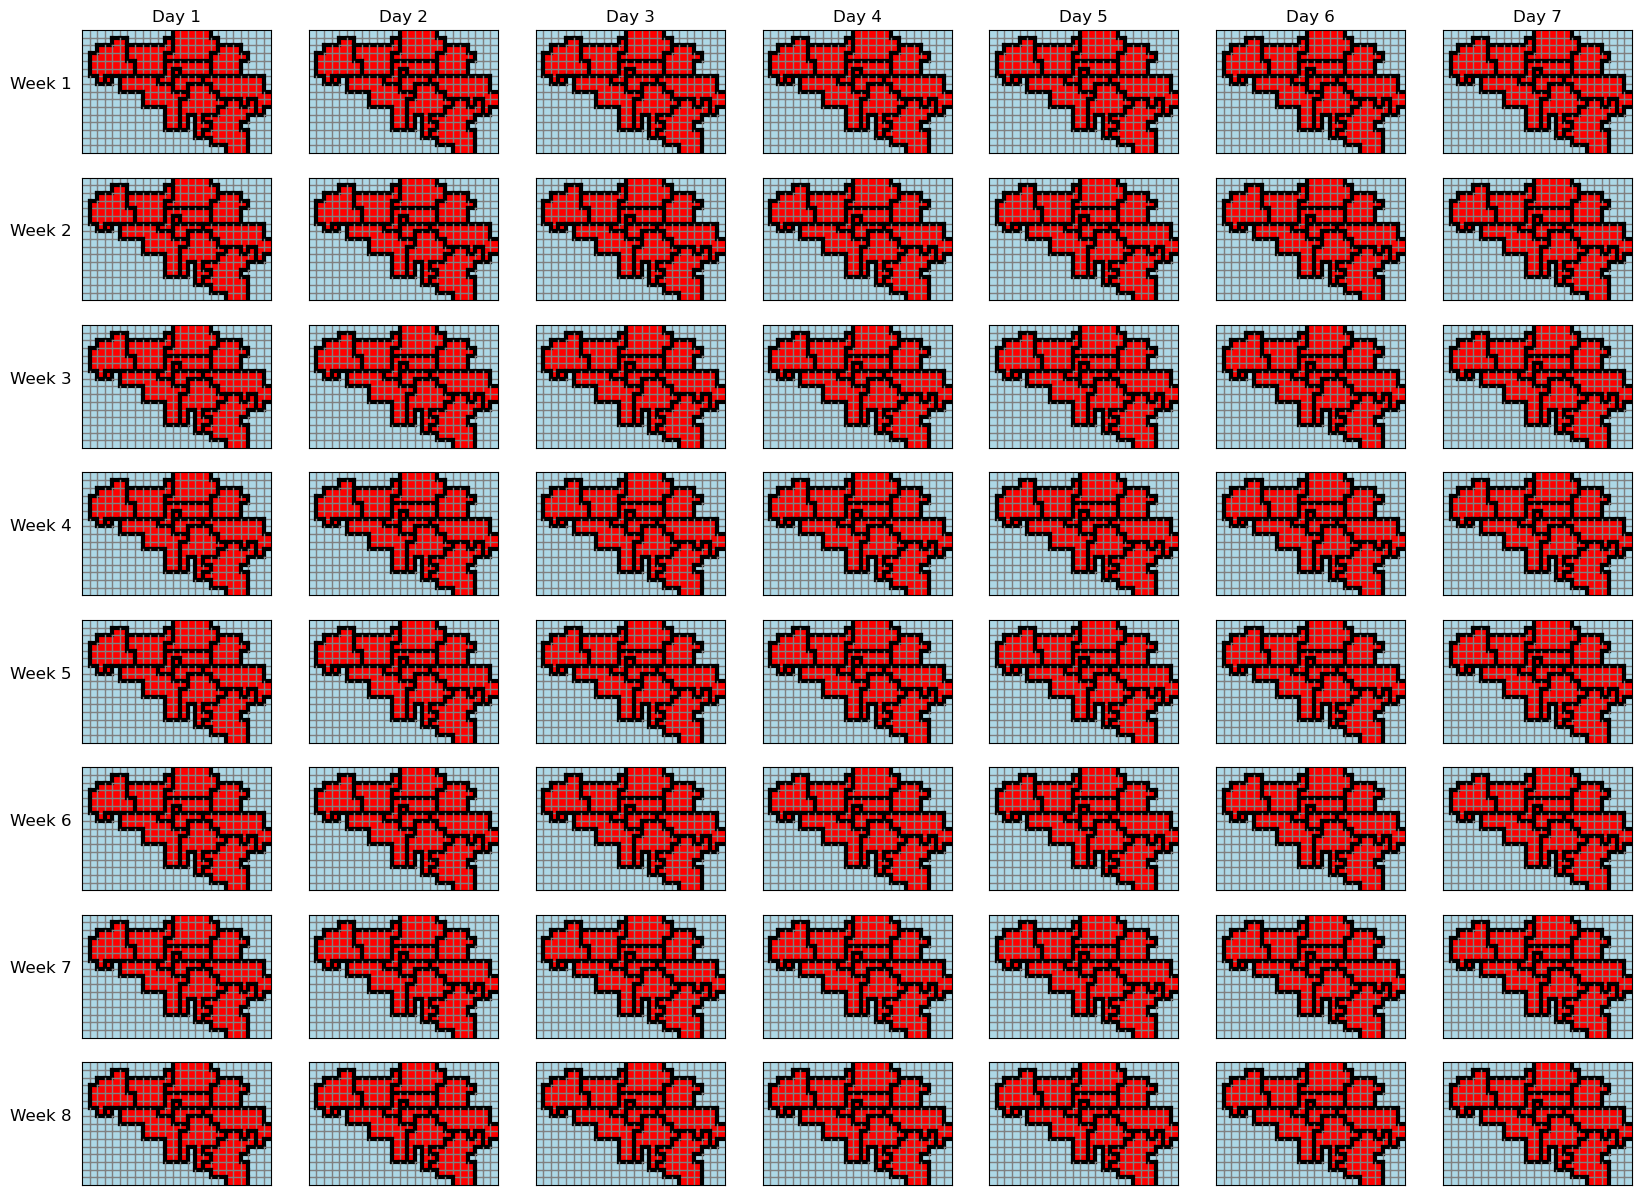

In [23]:
draw_color_map(grid,ca_infected,8,20,15)

In [24]:
q = find_q(delta_I, p)

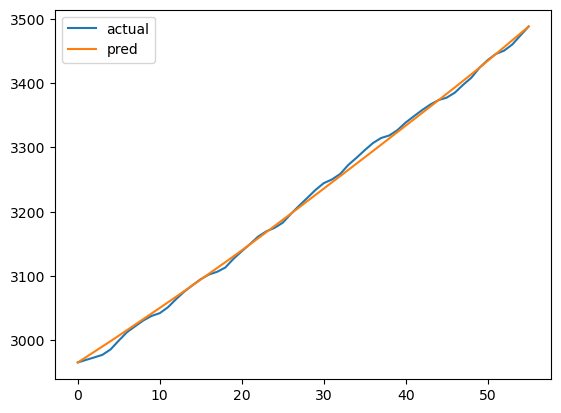

In [31]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

In [32]:
actual=calculate_ca(prediction_days,grid,test_infected)
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))

p=calculate_p(actual)

m=actual[0]
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
    print("Pred:",m.sum())
    print("Actual:",actual[i].sum())
prediction[-1]=calculate_m_bar(m) 

Pred: 754966.5996612003
Actual: 755333.0
Pred: 757269.0900602227
Actual: 757351.9999999999
Pred: 759568.6531602318
Actual: 758060.0
Pred: 761876.0026112683
Actual: 760059.0
Pred: 764175.4781853115
Actual: 763230.0
Pred: 766482.3973017938
Actual: 765801.0
Pred: 768792.8287601995
Actual: 768510.0
Pred: 771107.2196486222
Actual: 771228.0
Pred: 773431.2051160482
Actual: 773243.0
Pred: 775755.5049450198
Actual: 774329.0000000001
Pred: 778084.7310997652
Actual: 776433.0
Pred: 780410.4769958076
Actual: 779781.0
Pred: 782774.3501731621
Actual: 783208.0


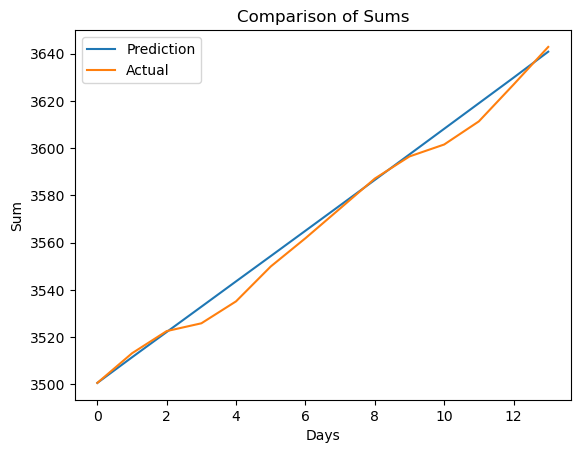

In [33]:
prediction_sums = [prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums = [actual[i].sum()/total_cells for i in range(prediction_days)]

plt.plot(range(prediction_days), actual_sums, label="Actual")
plt.plot(range(prediction_days), prediction_sums, label="Prediction")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sum")
plt.title("Comparison of Sums")
plt.show()

# Germany

In [15]:
grid = np.array([
    [0,0,0,0,14,14,14,0,0,0,0,0,0,0],
    [0,0,0,0,14,14,14,14,0,0,8,8,0,0],
    [0,0,0,0,0,14,14,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,6,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,5,5,8,4,8,4,4,0],
    [0,0,5,5,5,5,5,5,13,4,4,4,4,0],
    [0,5,5,5,9,5,5,5,13,13,4,3,4,0],
    [0,9,9,9,9,5,5,13,13,13,4,4,4,0],
    [9,9,9,9,9,9,5,13,13,13,13,4,4,0],
    [9,9,9,9,7,7,15,15,15,13,12,12,12,12],
    [9,9,9,9,7,7,15,15,15,15,12,12,12,12],
    [0,9,10,10,7,7,2,15,15,12,12,0,0,0],
    [0,10,10,10,7,2,2,2,2,2,0,0,0,0],
    [0,10,10,10,7,1,2,2,2,2,0,0,0,0],
    [0,11,11,10,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,2,0,0],
    [0,0,0,1,1,1,2,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,0,1,2,2,2,0,2,0,0,0]
])
days =6*7
prediction_days=2*7

final_df = pd.read_csv('data/germany/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))
final_df= final_df[final_df['Country/Region']=='Germany']

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/germany/regions.csv')

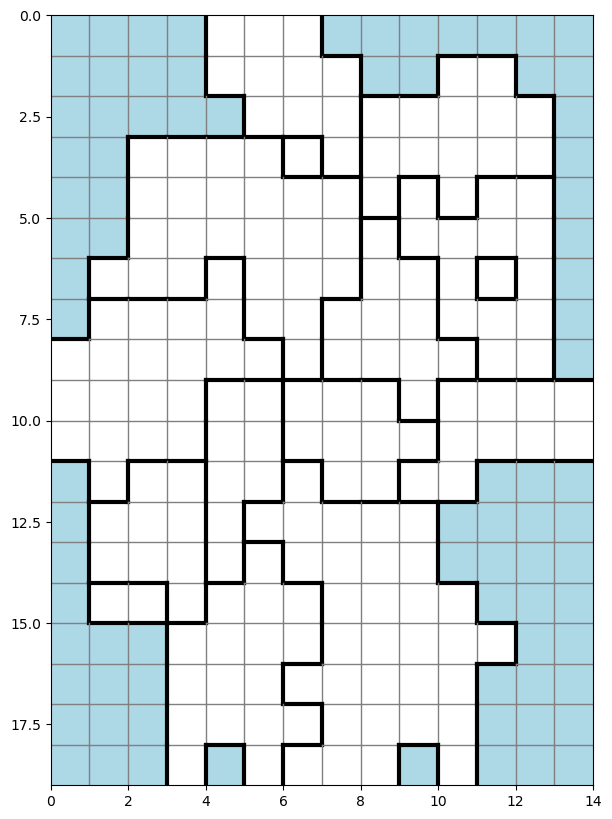

In [16]:
draw_map(grid,7,10)

In [41]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

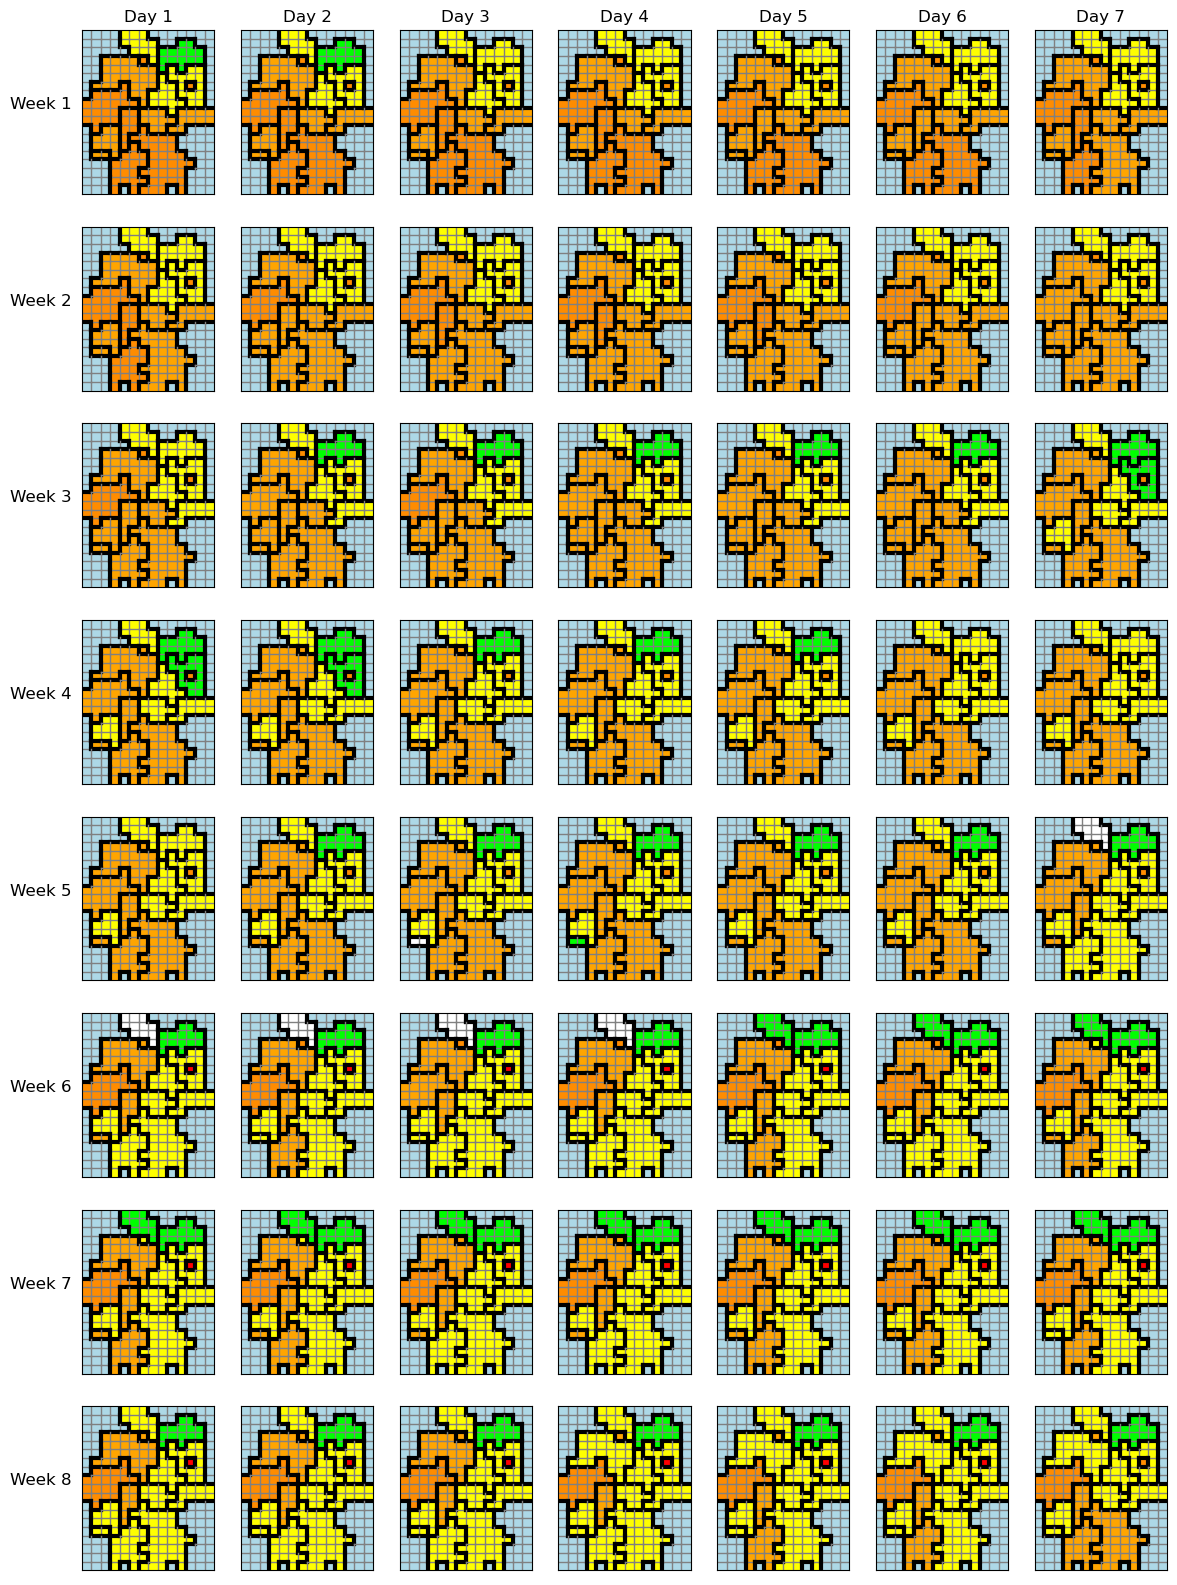

In [13]:
draw_color_map(grid,ca_infected,8,14,20)

In [42]:
q = find_q(delta_I, p)

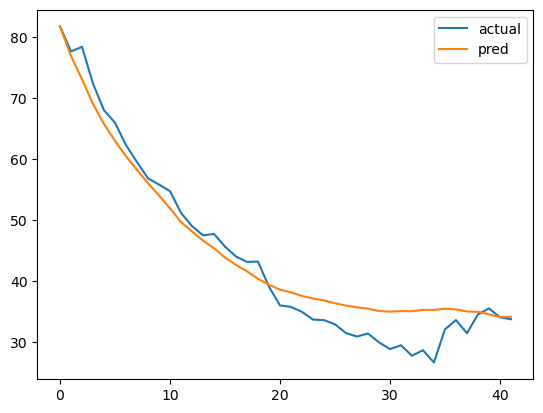

In [43]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

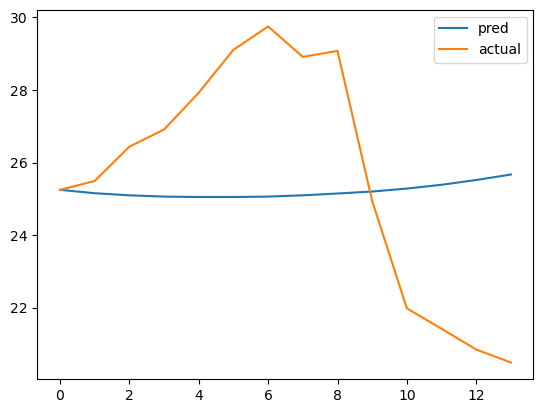

In [44]:
actual=calculate_ca(prediction_days,grid,test_infected)
m=actual[0]
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    p_bar=calculate_p_bar(m_bar)
    m=calculate_m(m_bar,p_bar,q)
prediction[-1]=calculate_m_bar(m) 
pred_sums=[prediction[i].sum()/258 for i in range(prediction_days)]
actual_sums=[actual[i].sum()/258 for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

In [20]:
actual=calculate_ca(prediction_days,grid,test_infected)
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))

p=calculate_p(actual)

m=actual[0]
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
    print("Pred:",m.sum())
    print("Actual:",actual[i].sum())
prediction[-1]=calculate_m_bar(m) 

Pred: 5166.495081694722
Actual: 5223.0
Pred: 5177.268638120335
Actual: 5290.0
Pred: 5185.3297698868555
Actual: 5363.0
Pred: 5175.106912222304
Actual: 5540.0
Pred: 5153.427810221818
Actual: 5467.0
Pred: 5145.008133840556
Actual: 5289.0
Pred: 5171.174620729447
Actual: 5439.0
Pred: 5169.283703226917
Actual: 5557.0
Pred: 5145.357298482586
Actual: 5647.0
Pred: 5121.29954712401
Actual: 5277.0
Pred: 5116.591531165761
Actual: 4912.0
Pred: 5161.450553769521
Actual: 5194.0
Pred: 5188.444595454505
Actual: 5276.0


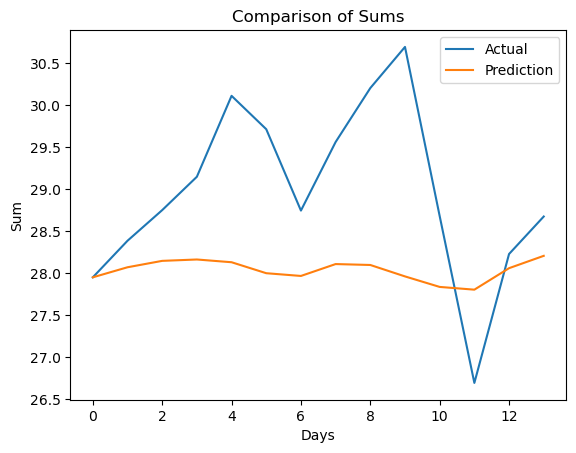

In [21]:
prediction_sums = [prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums = [actual[i].sum()/total_cells for i in range(prediction_days)]

plt.plot(range(prediction_days), actual_sums, label="Actual")
plt.plot(range(prediction_days), prediction_sums, label="Prediction")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sum")
plt.title("Comparison of Sums")
plt.show() 

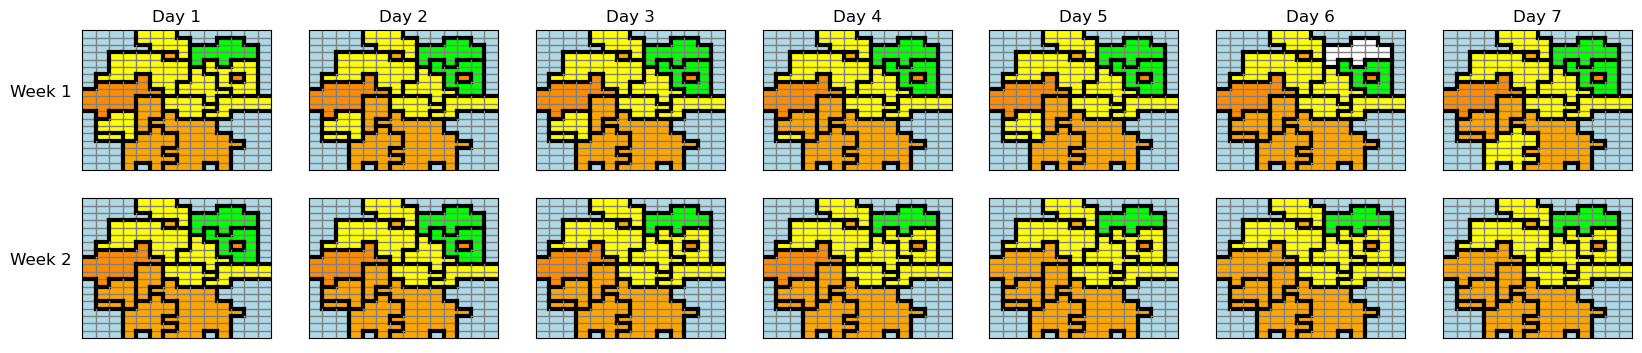

In [20]:
draw_color_map(grid,actual,2,20,4)

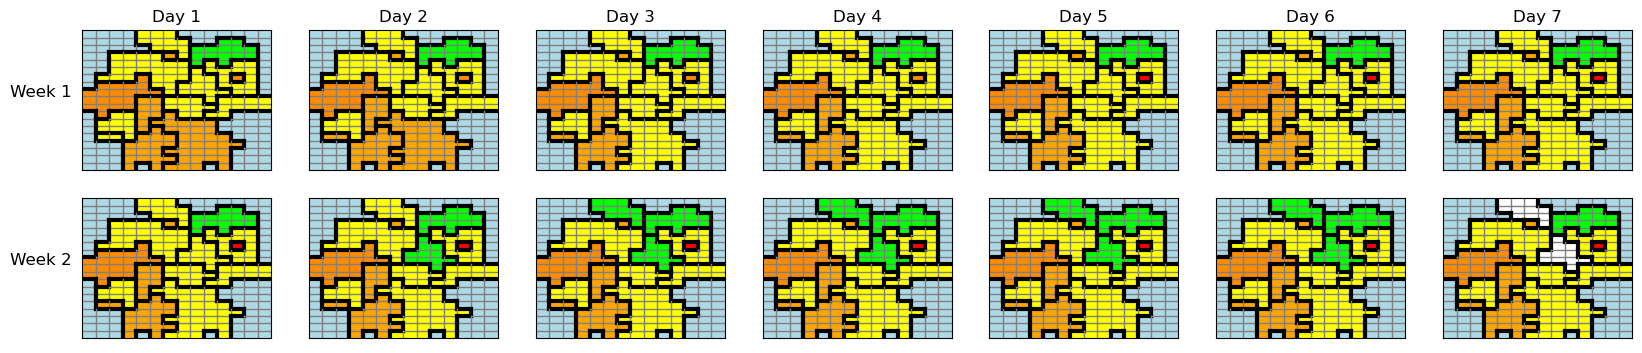

In [21]:
draw_color_map(grid,prediction,2,20,4)

# Malaysia

In [22]:
grid = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,0,0,0,0],
    [8,8,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,0,0,0],
    [8,0,2,2,2,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,10,10,10,0],
    [0,0,0,2,2,0,7,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,10,10,10,10],
    [0,0,9,9,2,7,7,3,3,13,13,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,11,10,10,10,10,10,10,0,0],
    [0,0,0,7,7,7,3,3,3,13,13,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,11,11,11,11,0,0,0,0,0,0,0],
    [0,0,0,7,7,7,3,3,3,3,13,13,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,11,11,11,0,0,0,0,0,0,0,0],
    [0,0,0,7,7,7,6,6,6,6,6,13,13,0,0,0,0,0,0,0,0,0,0,11,11,11,11,11,11,11,11,0,0,0,0,0,0,0,0],
    [0,0,0,0,7,7,7,6,6,6,6,13,13,0,0,0,0,0,0,0,0,0,0,11,11,11,11,11,11,11,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,12,7,7,6,6,6,6,6,0,0,0,0,0,0,0,0,11,0,11,11,11,11,11,11,11,11,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,12,12,6,6,6,6,6,6,0,0,0,0,0,0,0,11,11,11,11,11,0,0,11,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,12,12,12,5,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,14,5,5,5,1,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,5,4,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])
days = 8*7
prediction_days=2*7

final_df = pd.read_csv('data/malaysia/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))
final_df= final_df[final_df['Country/Region']=='Malaysia']

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/malaysia/regions.csv')

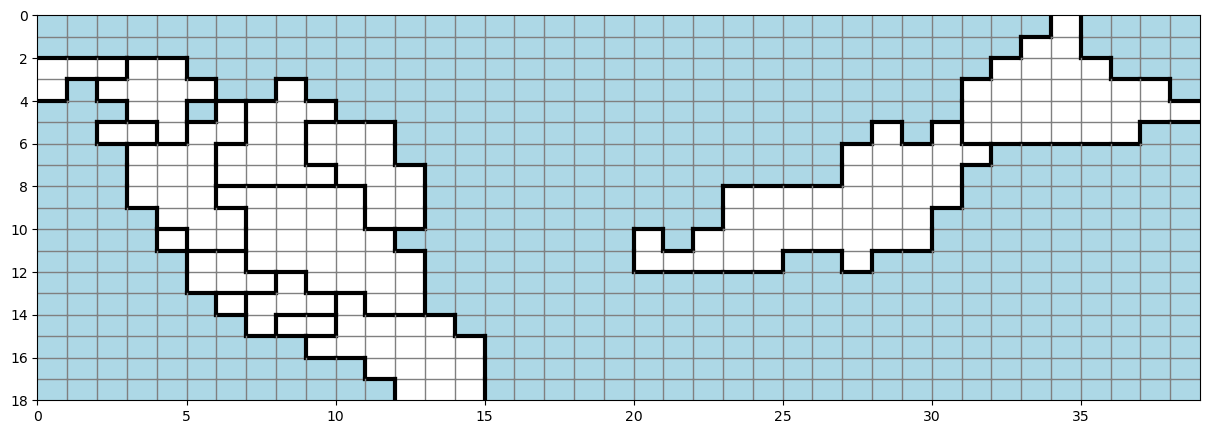

In [23]:
draw_map(grid,15,5)

In [24]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

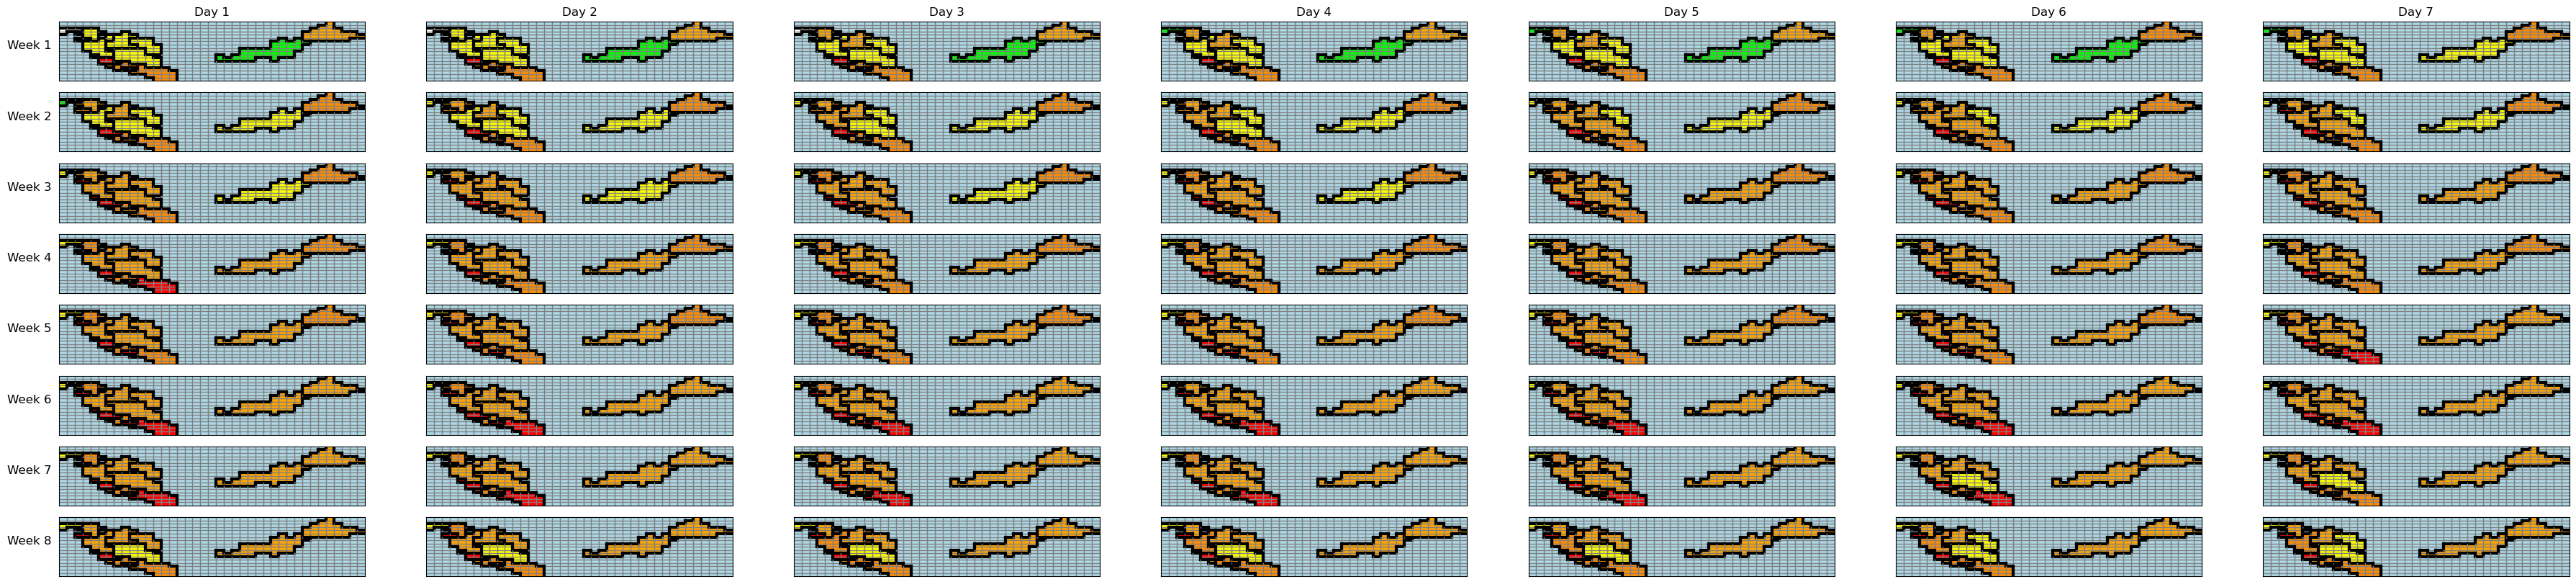

In [113]:
draw_color_map(grid,ca_infected,8,45,10)

In [25]:
q = find_q(delta_I, p)

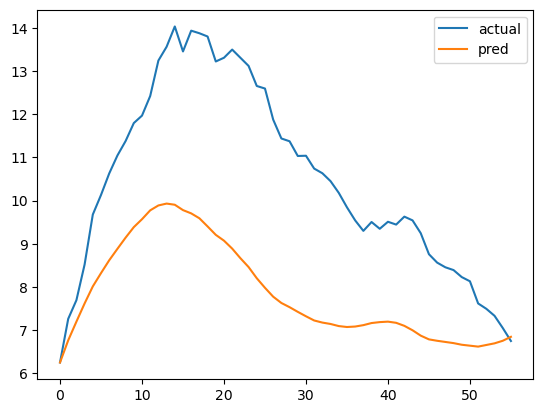

In [26]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

In [27]:
actual=calculate_ca(prediction_days,grid,test_infected)
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))

p=calculate_p(actual)

m=actual[0]
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
    print("Pred:",m.sum())
    print("Actual:",actual[i].sum())
prediction[-1]=calculate_m_bar(m) 

Pred: 1237.311800075228
Actual: 1212.9999999999998
Pred: 1258.2134651448896
Actual: 1219.0000000000002
Pred: 1280.8881167077845
Actual: 1190.0
Pred: 1308.5159336033253
Actual: 1149.0
Pred: 1335.1270532488013
Actual: 1163.9999999999998
Pred: 1360.744257910166
Actual: 1159.0
Pred: 1383.9981529993568
Actual: 1186.0000000000002
Pred: 1403.4092238948651
Actual: 1323.9999999999998
Pred: 1400.586392719996
Actual: 1448.9999999999998
Pred: 1376.0988676727968
Actual: 1422.0000000000002
Pred: 1352.6902030316453
Actual: 1346.0
Pred: 1335.4531536593288
Actual: 1383.0
Pred: 1311.01658843459
Actual: 1317.9999999999998


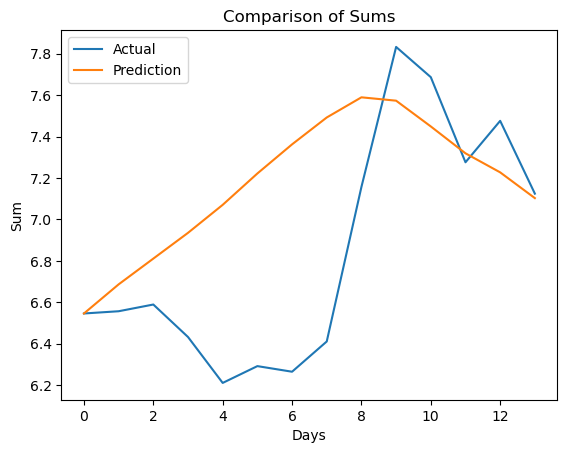

In [28]:
prediction_sums = [prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums = [actual[i].sum()/total_cells for i in range(prediction_days)]


plt.plot(range(prediction_days), actual_sums, label="Actual")
plt.plot(range(prediction_days), prediction_sums, label="Prediction")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sum")
plt.title("Comparison of Sums")
plt.show() 

# Italy

In [ ]:
grid = np.array([
    [0,0,0,0,0,12,12,12,0,0,0,0,0,0,0],
    [0,0,13,9,9,12,12,20,6,0,0,0,0,0,0],
    [0,19,13,9,9,12,20,6,6,0,0,0,0,0,0],
    [0,13,13,9,9,20,20,20,6,0,0,0,0,0,0],
    [13,13,13,9,9,9,20,0,0,0,0,0,0,0,0],
    [13,13,13,5,5,5,5,0,0,0,0,0,0,0,0],
    [0,13,8,8,5,5,5,0,0,0,0,0,0,0,0],
    [0,8,0,0,17,17,5,0,0,0,0,0,0,0,0],
    [0,0,0,0,17,17,17,10,10,0,0,0,0,0,0],
    [0,0,0,0,17,17,18,10,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,18,18,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,7,7,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,7,11,14,14,0,0,0],
    [0,0,15,0,0,0,0,7,7,4,14,14,0,0,0],
    [0,15,15,0,0,0,0,0,4,4,2,14,14,0,0],
    [0,15,15,0,0,0,0,0,0,4,4,2,14,14,0],
    [0,15,15,0,0,0,0,0,0,0,4,2,0,14,14],
    [0,15,15,0,0,0,0,0,0,0,0,3,0,0,14],
    [0,15,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,0,0,0],
    [0,0,0,0,0,0,16,16,0,16,16,3,0,0,0],
    [0,0,0,0,0,0,16,16,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,16,0,0,0,0,0]
])
days = 6*7
prediction_days=2*7

final_df = pd.read_csv('data/italy/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))
final_df= final_df[final_df['Country/Region']=='Italy']

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/italy/regions.csv')

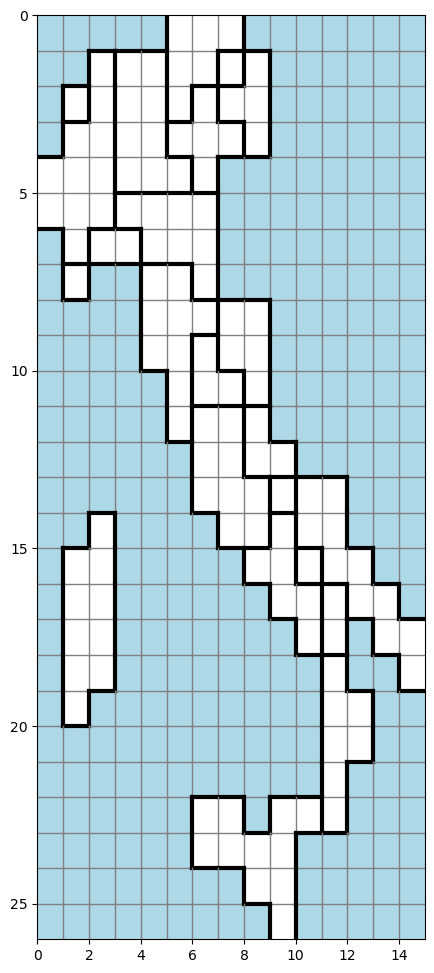

In [25]:
draw_map(grid,5,12)

In [27]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

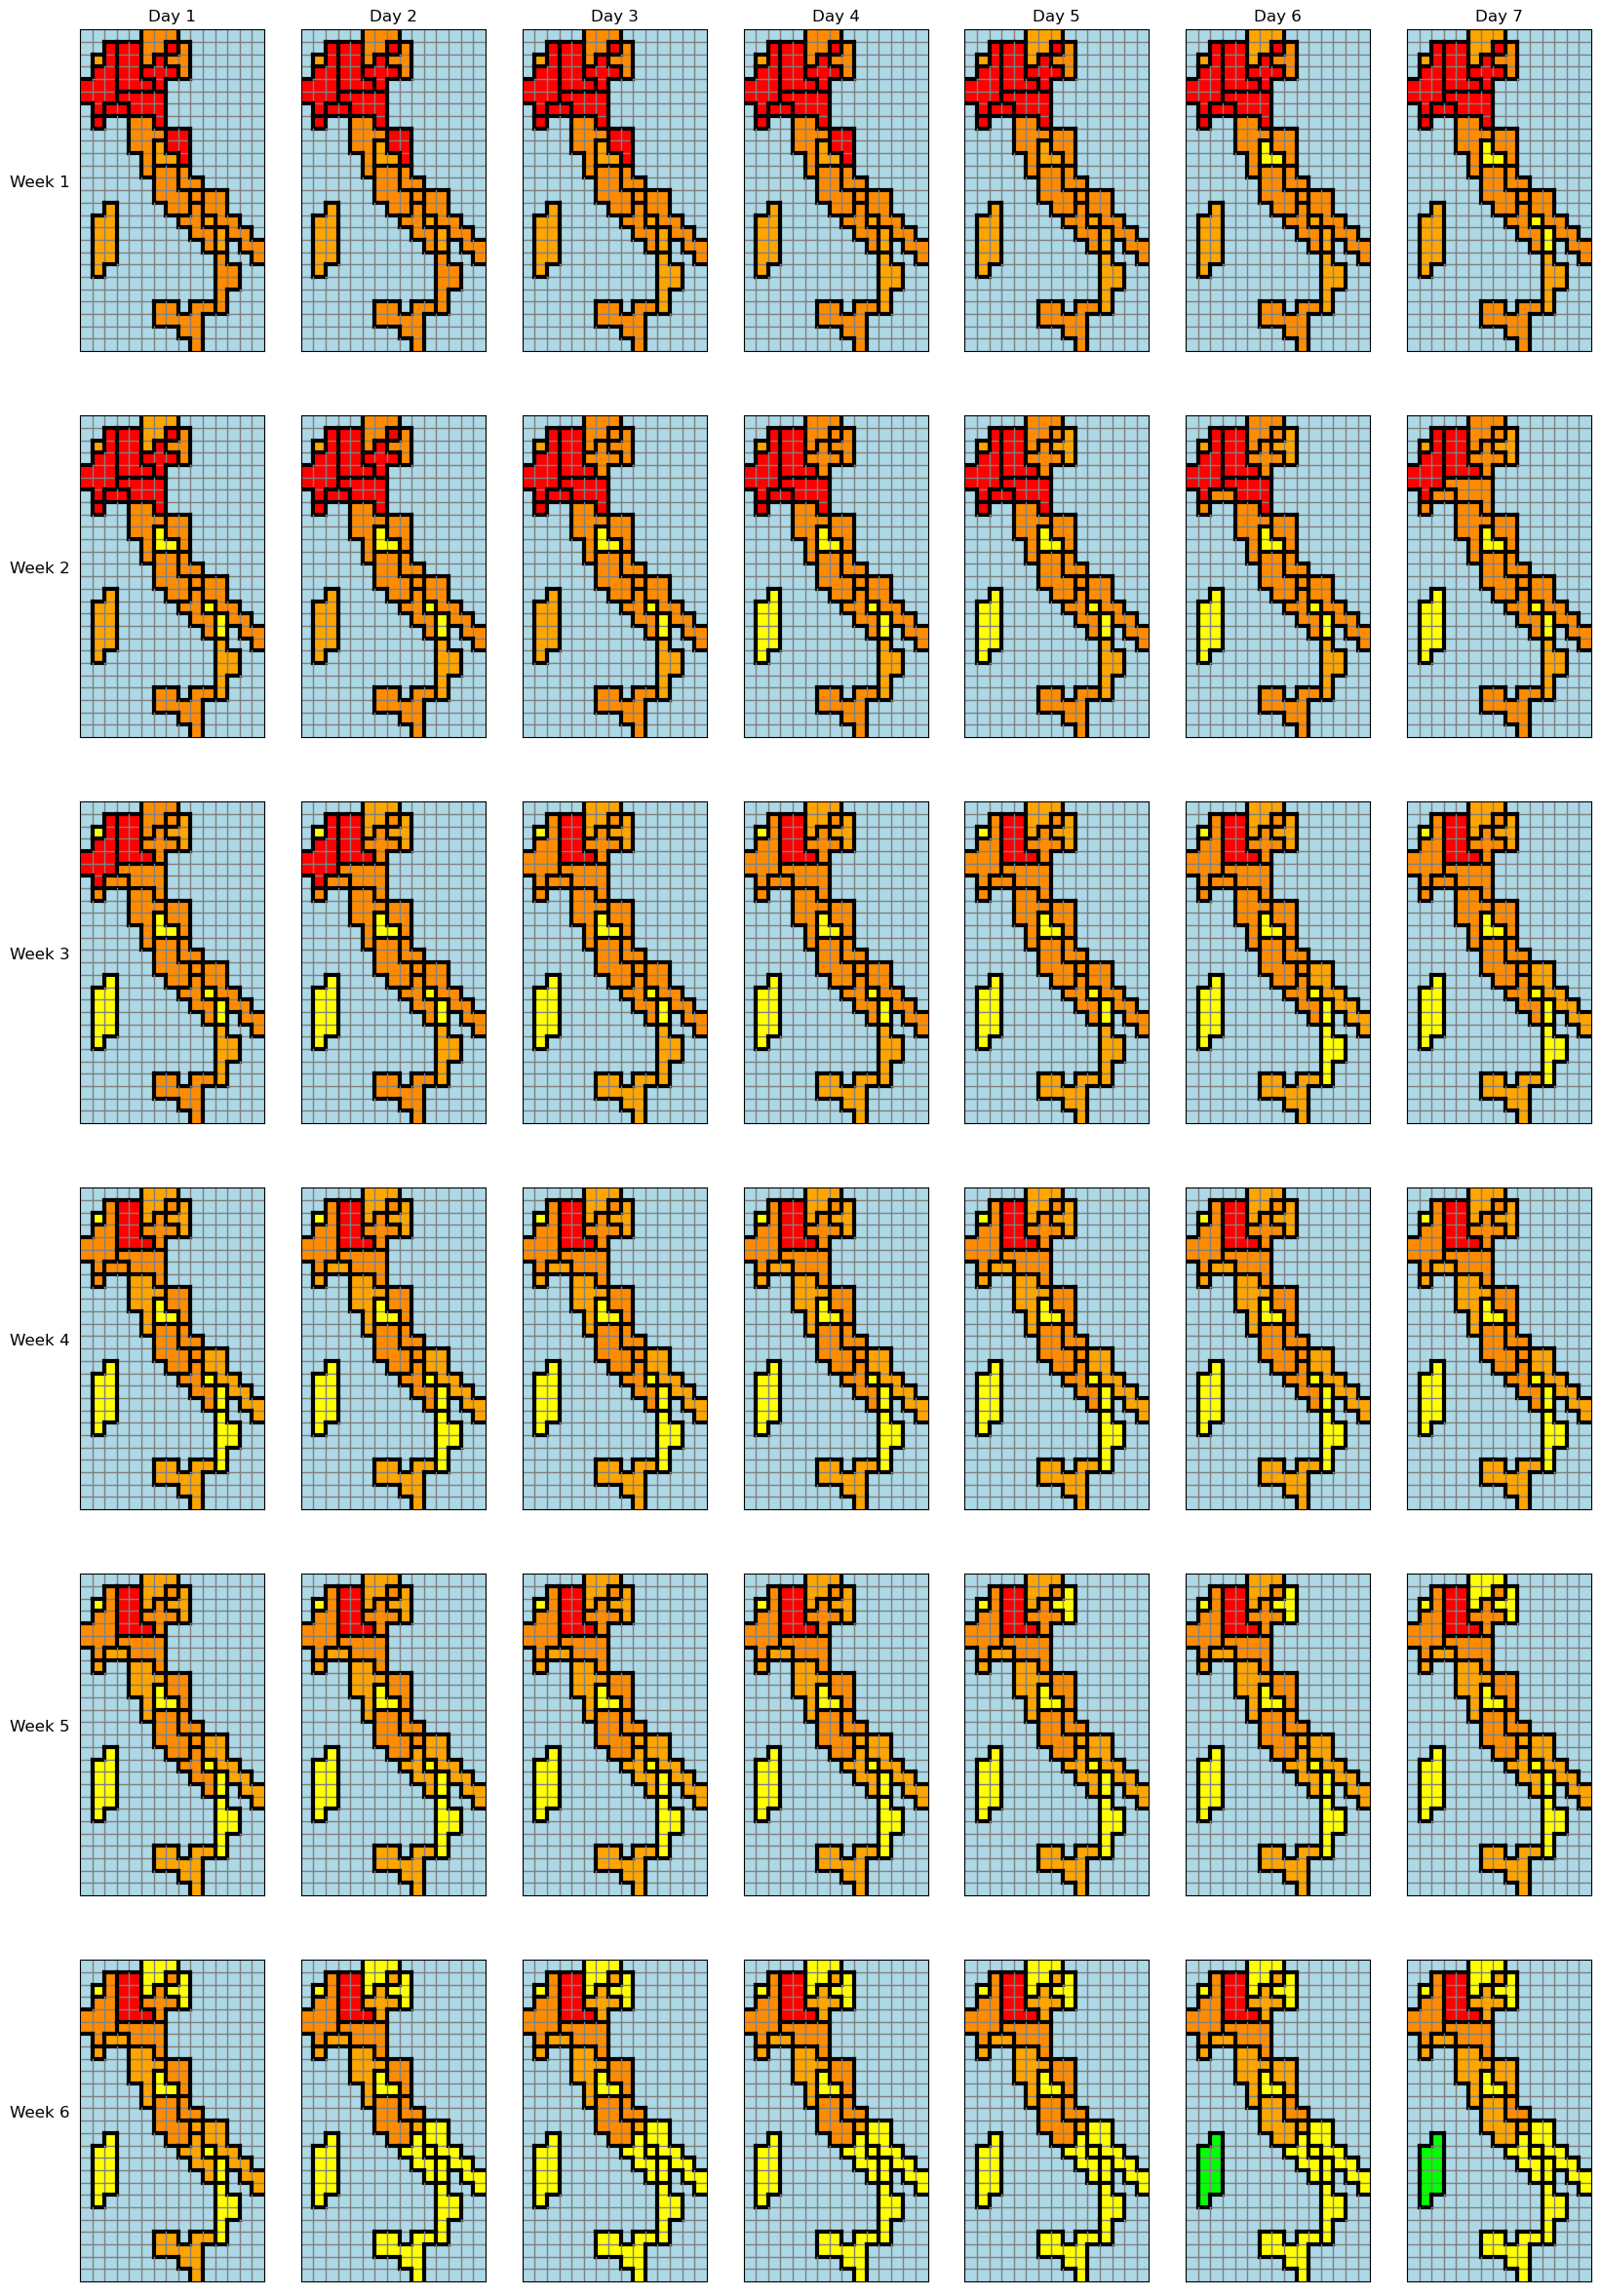

In [28]:
draw_color_map(grid,ca_infected,6,20,30)

In [29]:
q = find_q(delta_I, p)

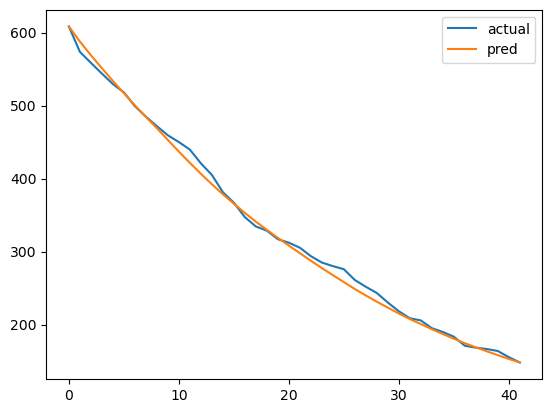

In [30]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

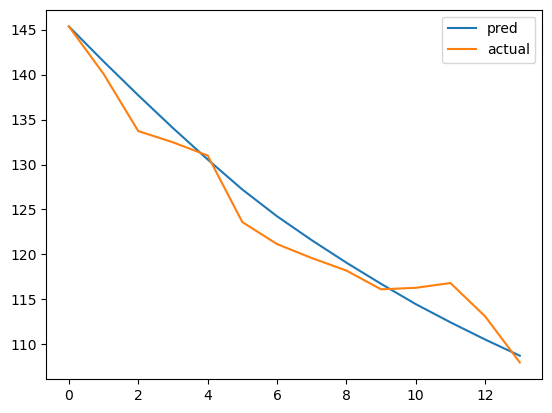

In [31]:
actual=calculate_ca(prediction_days,grid,test_infected)
m=actual[0]
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    p_bar=calculate_p_bar(m_bar)
    m=calculate_m(m_bar,p_bar,q)
prediction[-1]=calculate_m_bar(m) 
pred_sums=[prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums=[actual[i].sum()/total_cells for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

In [32]:
actual=calculate_ca(prediction_days,grid,test_infected)
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))

p=calculate_p(actual)

m=actual[0]
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
    print("Pred:",m.sum())
    print("Actual:",actual[i].sum())
prediction[-1]=calculate_m_bar(m) 

Pred: 17824.02539683068
Actual: 17650.0
Pred: 17378.28441648226
Actual: 16848.399999999998
Pred: 16995.646305609007
Actual: 16691.4
Pred: 16613.818910382062
Actual: 16506.4
Pred: 16242.19611065324
Actual: 15573.800000000001
Pred: 15925.933973134537
Actual: 15265.400000000001
Pred: 15648.374522999955
Actual: 15069.999999999998
Pred: 15408.60042164528
Actual: 14893.999999999998
Pred: 15210.229360201734
Actual: 14631.4
Pred: 15058.127586004628
Actual: 14652.4
Pred: 14911.243094180594
Actual: 14719.4
Pred: 14774.417938015271
Actual: 14252.8
Pred: 14686.973867022256
Actual: 13606.2


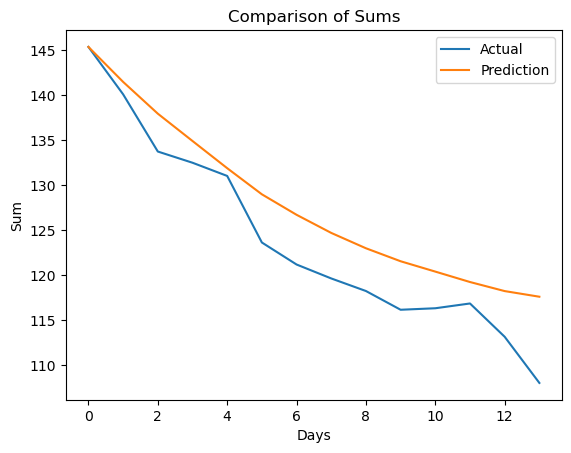

In [33]:
prediction_sums = [prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums = [actual[i].sum()/total_cells for i in range(prediction_days)]


plt.plot(range(prediction_days), actual_sums, label="Actual")
plt.plot(range(prediction_days), prediction_sums, label="Prediction")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sum")
plt.title("Comparison of Sums")
plt.show() 

# Switzerland

In [16]:
germany_grid = np.array([
    [0,0,0,0,14,14,14,0,0,0,0,0,0,0],
    [0,0,0,0,14,14,14,14,0,0,8,8,0,0],
    [0,0,0,0,0,14,14,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,6,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,5,5,8,4,8,4,4,0],
    [0,0,5,5,5,5,5,5,13,4,4,4,4,0],
    [0,5,5,5,9,5,5,5,13,13,4,3,4,0],
    [0,9,9,9,9,5,5,13,13,13,4,4,4,0],
    [9,9,9,9,9,9,5,13,13,13,13,4,4,0],
    [9,9,9,9,7,7,15,15,15,13,12,12,12,12],
    [9,9,9,9,7,7,15,15,15,15,12,12,12,12],
    [0,9,10,10,7,7,2,15,15,12,12,0,0,0],
    [0,10,10,10,7,2,2,2,2,2,0,0,0,0],
    [0,10,10,10,7,1,2,2,2,2,0,0,0,0],
    [0,11,11,10,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,2,0,0],
    [0,0,0,1,1,1,2,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,0,1,2,2,2,0,2,0,0,0]
])

max_val=np.max(germany_grid)
italy_grid = np.array([
    [0,0,0,0,0,12,12,12,0,0,0,0,0,0,0],
    [0,0,13,9,9,12,12,20,6,0,0,0,0,0,0],
    [0,19,13,9,9,12,20,6,6,0,0,0,0,0,0],
    [0,13,13,9,9,20,20,20,6,0,0,0,0,0,0],
    [13,13,13,9,9,9,20,0,0,0,0,0,0,0,0],
    [13,13,13,5,5,5,5,0,0,0,0,0,0,0,0],
    [0,13,8,8,5,5,5,0,0,0,0,0,0,0,0],
    [0,8,0,0,17,17,5,0,0,0,0,0,0,0,0],
    [0,0,0,0,17,17,17,10,10,0,0,0,0,0,0],
    [0,0,0,0,17,17,18,10,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,18,18,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,7,7,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,7,11,14,14,0,0,0],
    [0,0,15,0,0,0,0,7,7,4,14,14,0,0,0],
    [0,15,15,0,0,0,0,0,4,4,2,14,14,0,0],
    [0,15,15,0,0,0,0,0,0,4,4,2,14,14,0],
    [0,15,15,0,0,0,0,0,0,0,4,2,0,14,14],
    [0,15,15,0,0,0,0,0,0,0,0,3,0,0,14],
    [0,15,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,0,0,0],
    [0,0,0,0,0,0,16,16,0,16,16,3,0,0,0],
    [0,0,0,0,0,0,16,16,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,16,0,0,0,0,0]
])
italy_grid[italy_grid!=0]+=max_val

max_val=np.max(italy_grid)
switzerland_grid=np.array([
[0,0,0,0,0,1,0,0],
[0,0,1,1,1,1,0,0],
[0,0,1,1,1,1,0,0],
[0,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,0],
[1,0,1,1,1,1,1,0]
])
switzerland_grid[switzerland_grid!=0]+=max_val


grid=np.zeros((germany_grid.shape[0]+switzerland_grid.shape[0]+italy_grid.shape[0]-2,italy_grid.shape[1]+2))
grid[:germany_grid.shape[0],1:germany_grid.shape[1]+1]=germany_grid
grid[germany_grid.shape[0]-1,:switzerland_grid.shape[1]]+=switzerland_grid[0,:]
grid[germany_grid.shape[0]:germany_grid.shape[0]+switzerland_grid.shape[0]-1,:switzerland_grid.shape[1]]=switzerland_grid[1:,:]
grid[germany_grid.shape[0]+switzerland_grid.shape[0]-2,2:italy_grid.shape[1]+2]+=italy_grid[0,:]
grid[germany_grid.shape[0]+switzerland_grid.shape[0]-1:germany_grid.shape[0]+switzerland_grid.shape[0]+italy_grid.shape[0]-1,2:italy_grid.shape[1]+2]=italy_grid[1:,:]

days =6*7
prediction_days=2*7

final_df = pd.read_csv('data/switzerland/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/switzerland/regions.csv')

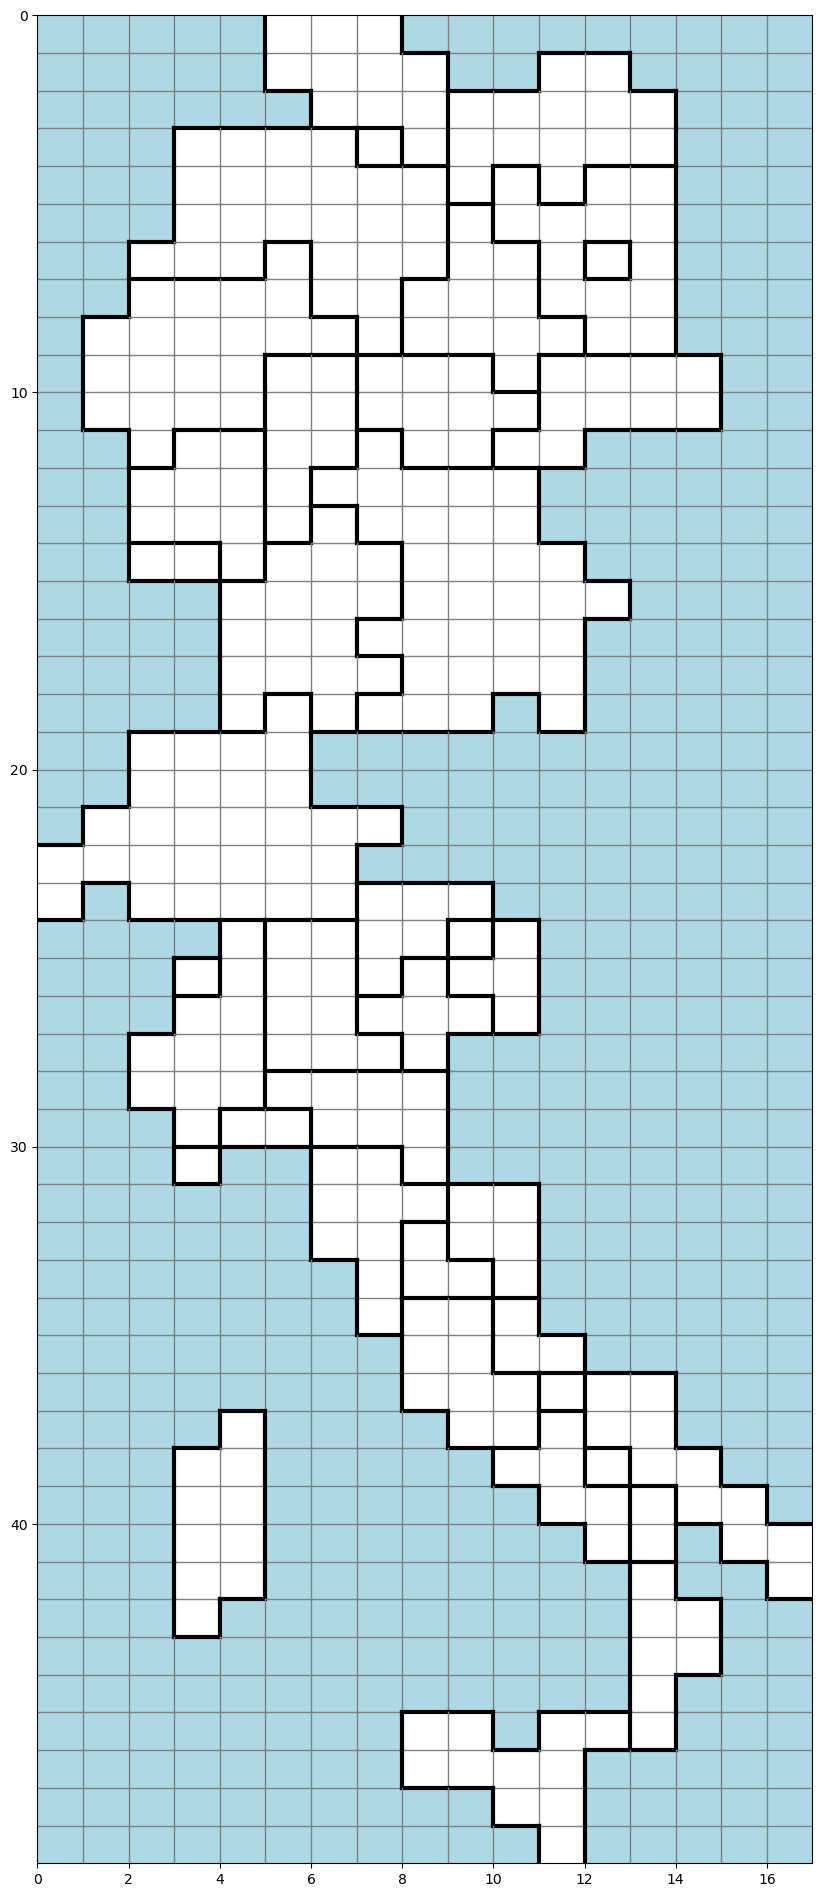

In [85]:
draw_map(grid,10,24)

In [17]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

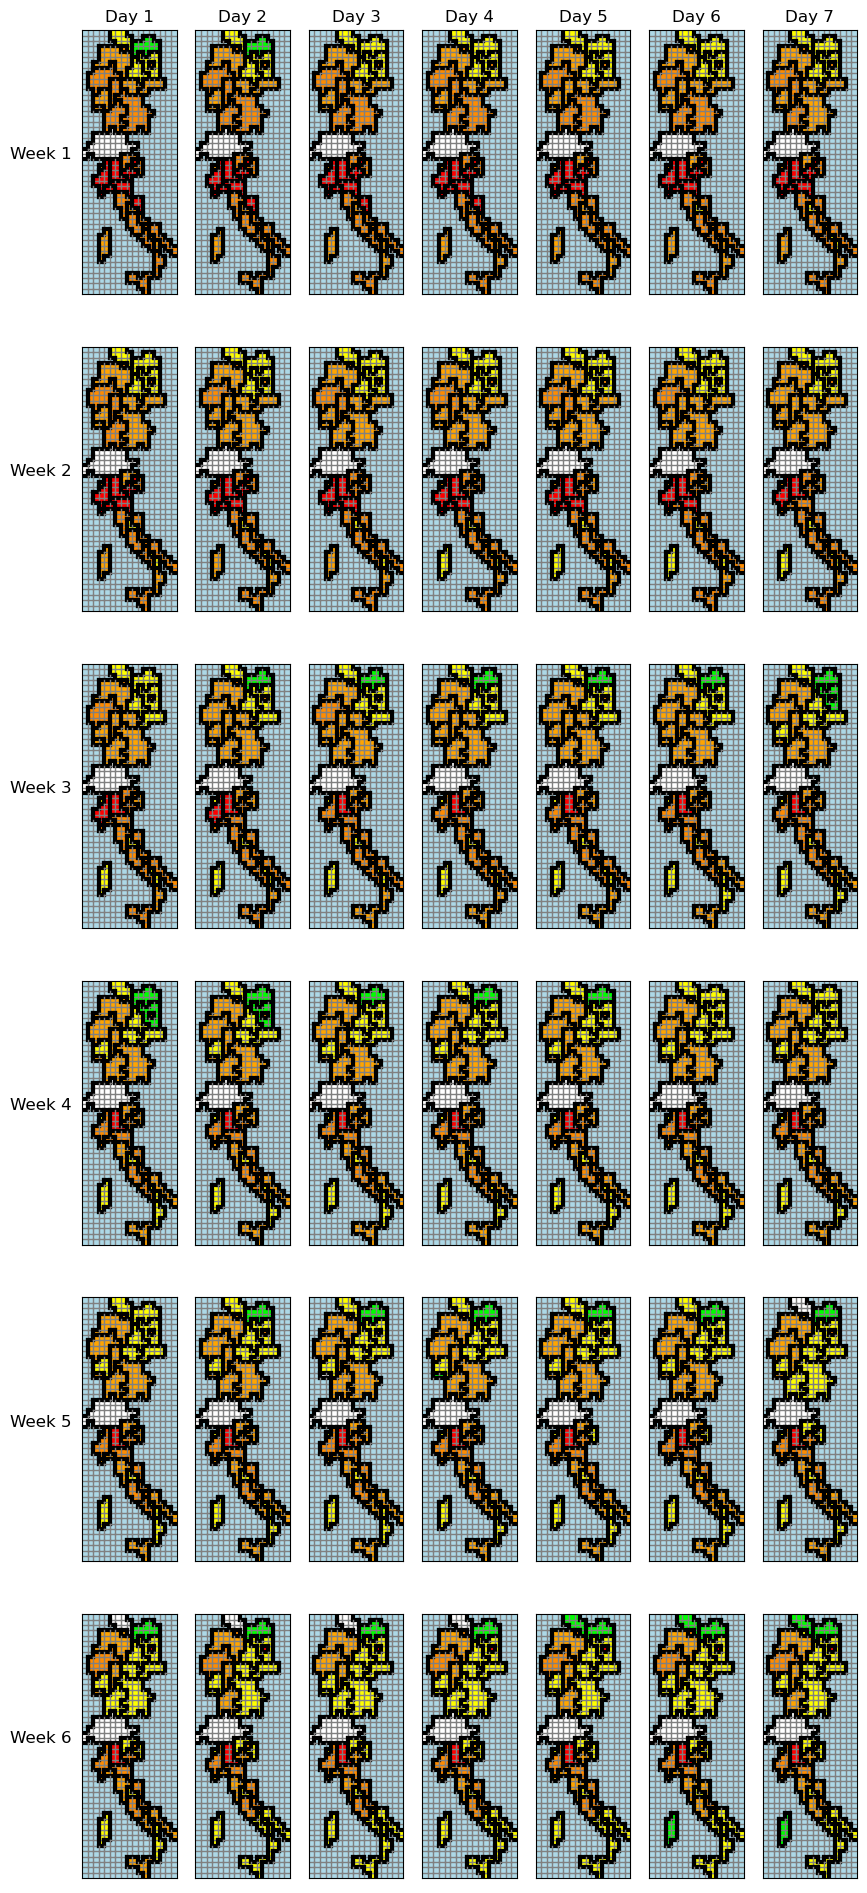

In [11]:
draw_color_map(grid,ca_infected,6,10,24)

In [23]:
q = find_q(delta_I, p)
indices=np.where(grid==36)
q[indices]=np.random.uniform(-0.01, 0.025, size=(len(indices[0]),6))

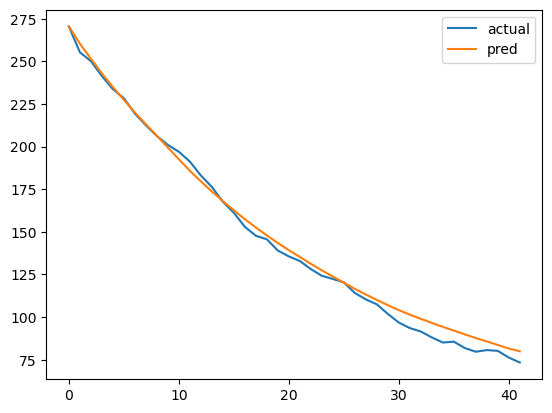

In [24]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

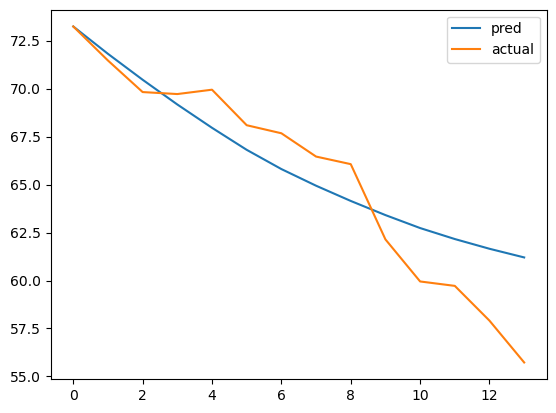

In [25]:
actual=calculate_ca(prediction_days,grid,test_infected)
m=actual[0]
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    p_bar=calculate_p_bar(m_bar)
    m=calculate_m(m_bar,p_bar,q)
prediction[-1]=calculate_m_bar(m) 
pred_sums=[prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums=[actual[i].sum()/total_cells for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

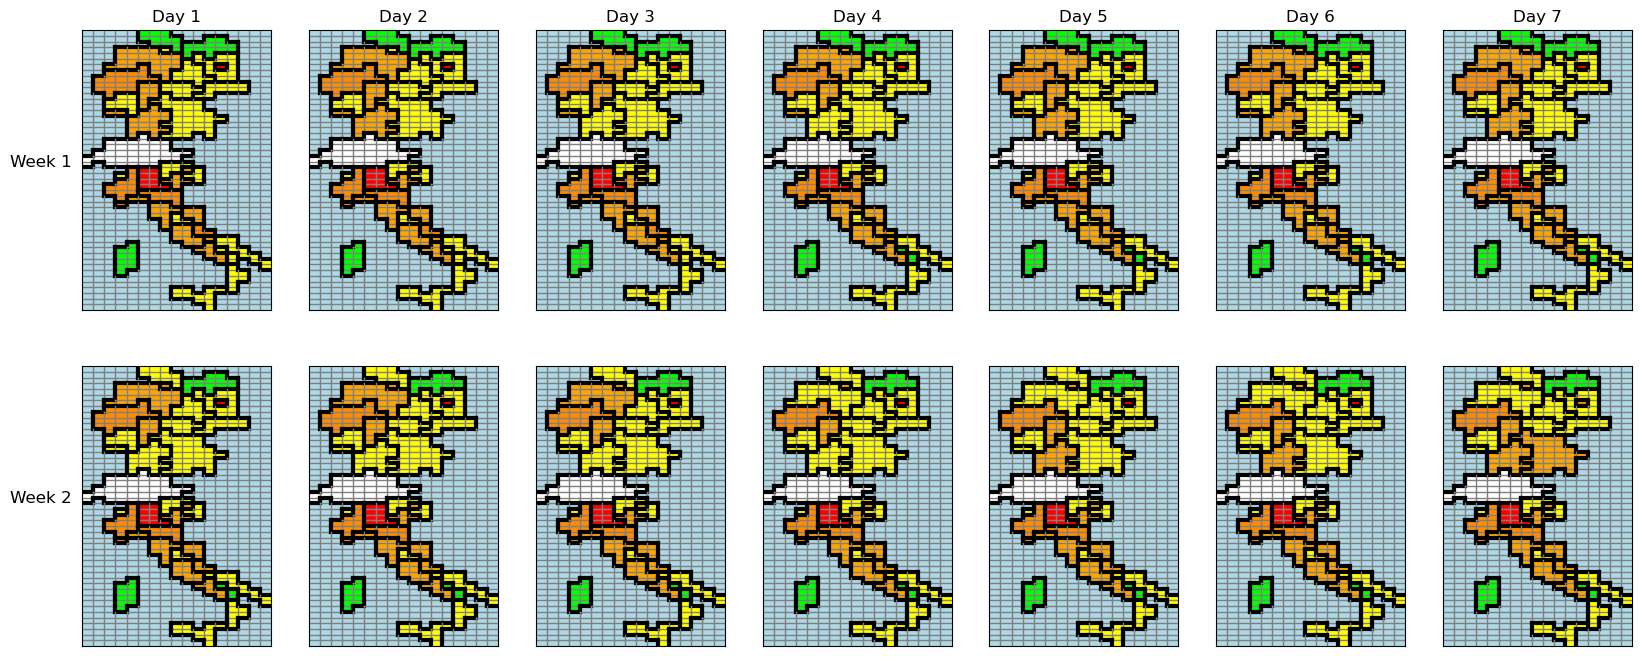

In [81]:
draw_color_map(grid,actual,2,20,8)

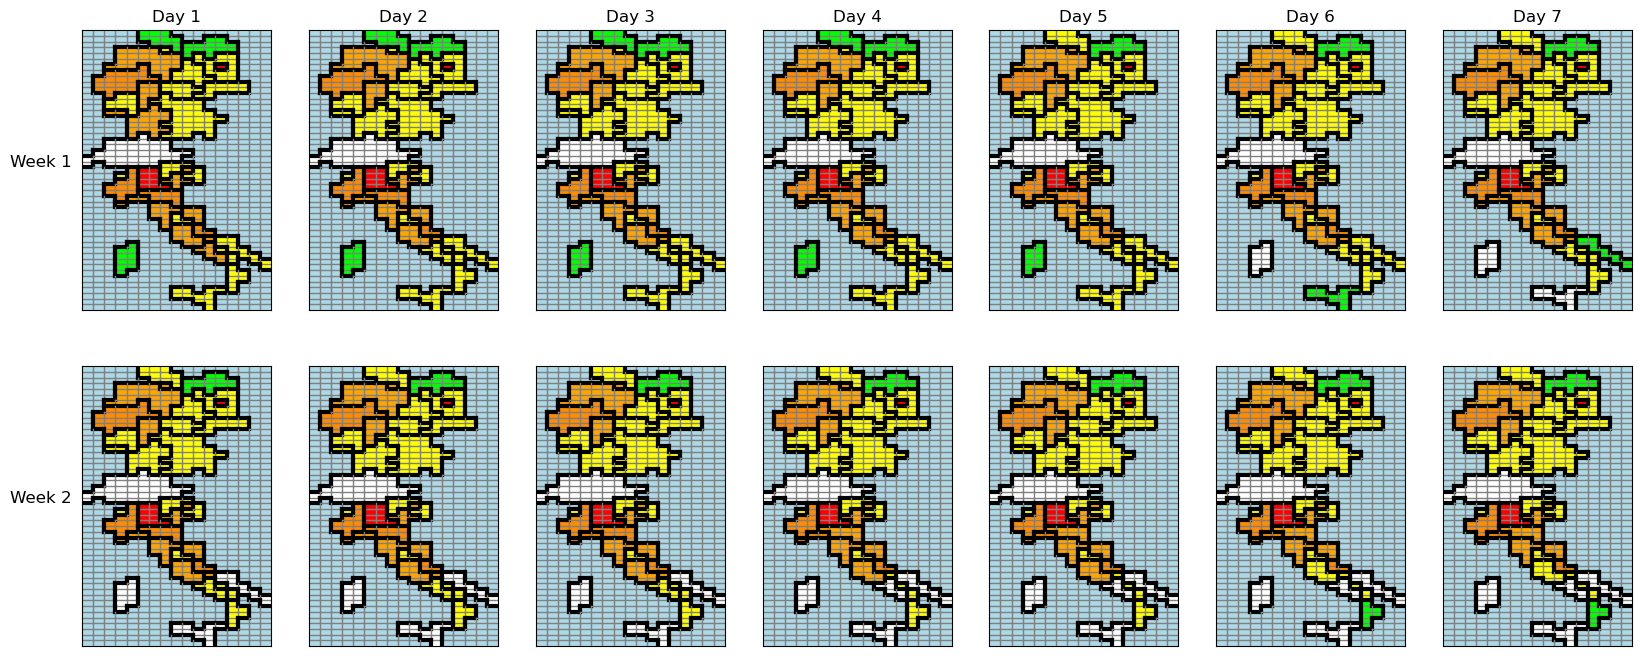

In [129]:
draw_color_map(grid,prediction,2,20,8)

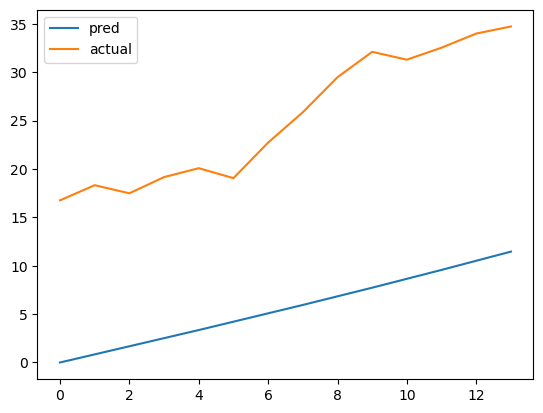

In [26]:
spread_actual=pd.read_csv('data/switzerland/actual.csv', usecols=range(4+days+prediction_days))
fixed_columns = spread_actual.iloc[:, :4]
variable_columns = spread_actual.iloc[:, 4:]
spread_actual=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)

indices=np.where(grid==36)
pred_sums=[prediction[i,indices[0],indices[1]].sum()/37 for i in range(prediction_days)]
actual_sums=[spread_actual.values[0,4+i]/37 for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

# France

In [77]:
germany_grid = np.array([
    [0,0,0,0,14,14,14,0,0,0,0,0,0,0],
    [0,0,0,0,14,14,14,14,0,0,8,8,0,0],
    [0,0,0,0,0,14,14,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,6,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,5,5,8,4,8,4,4,0],
    [0,0,5,5,5,5,5,5,13,4,4,4,4,0],
    [0,5,5,5,9,5,5,5,13,13,4,3,4,0],
    [0,9,9,9,9,5,5,13,13,13,4,4,4,0],
    [9,9,9,9,9,9,5,13,13,13,13,4,4,0],
    [9,9,9,9,7,7,15,15,15,13,12,12,12,12],
    [9,9,9,9,7,7,15,15,15,15,12,12,12,12],
    [0,9,10,10,7,7,2,15,15,12,12,0,0,0],
    [0,10,10,10,7,2,2,2,2,2,0,0,0,0],
    [0,10,10,10,7,1,2,2,2,2,0,0,0,0],
    [0,11,11,10,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,2,0,0],
    [0,0,0,1,1,1,2,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,0,1,2,2,2,0,2,0,0,0]
])

max_val=np.max(germany_grid)
italy_grid = np.array([
    [0,0,0,0,0,12,12,12,0,0,0,0,0,0,0],
    [0,0,13,9,9,12,12,20,6,0,0,0,0,0,0],
    [0,19,13,9,9,12,20,6,6,0,0,0,0,0,0],
    [0,13,13,9,9,20,20,20,6,0,0,0,0,0,0],
    [13,13,13,9,9,9,20,0,0,0,0,0,0,0,0],
    [13,13,13,5,5,5,5,0,0,0,0,0,0,0,0],
    [0,13,8,8,5,5,5,0,0,0,0,0,0,0,0],
    [0,8,0,0,17,17,5,0,0,0,0,0,0,0,0],
    [0,0,0,0,17,17,17,10,10,0,0,0,0,0,0],
    [0,0,0,0,17,17,18,10,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,18,18,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,7,7,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,7,11,14,14,0,0,0],
    [0,0,15,0,0,0,0,7,7,4,14,14,0,0,0],
    [0,15,15,0,0,0,0,0,4,4,2,14,14,0,0],
    [0,15,15,0,0,0,0,0,0,4,4,2,14,14,0],
    [0,15,15,0,0,0,0,0,0,0,4,2,0,14,14],
    [0,15,15,0,0,0,0,0,0,0,0,3,0,0,14],
    [0,15,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,0,0,0],
    [0,0,0,0,0,0,16,16,0,16,16,3,0,0,0],
    [0,0,0,0,0,0,16,16,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,16,0,0,0,0,0]
])
italy_grid[italy_grid!=0]+=max_val

max_val=np.max(italy_grid)
france_grid=np.array([
[1,0,0,0,0],
[1,1,1,0,0],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,0],
[1,1,1,1,0],
[1,1,1,0,0],
[1,1,0,0,0],    
[1,1,0,1,0],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,0],
[1,1,1,1,0],
[1,1,1,1,1],
[0,1,1,1,0]
])
france_grid[france_grid!=0]+=max_val


grid=np.zeros((germany_grid.shape[0]+italy_grid.shape[0]+4,italy_grid.shape[1]+france_grid.shape[1]))
grid[:germany_grid.shape[0],2:germany_grid.shape[1]+2]=germany_grid
grid[germany_grid.shape[0]-6:germany_grid.shape[0]+11,:france_grid.shape[1]]+=france_grid
grid[germany_grid.shape[0]+3:germany_grid.shape[0]+italy_grid.shape[0]+3,france_grid.shape[1]-1:italy_grid.shape[1]+france_grid.shape[1]-1]+=italy_grid

days =6*7
prediction_days=2*7

final_df = pd.read_csv('data/france/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/france/regions.csv')

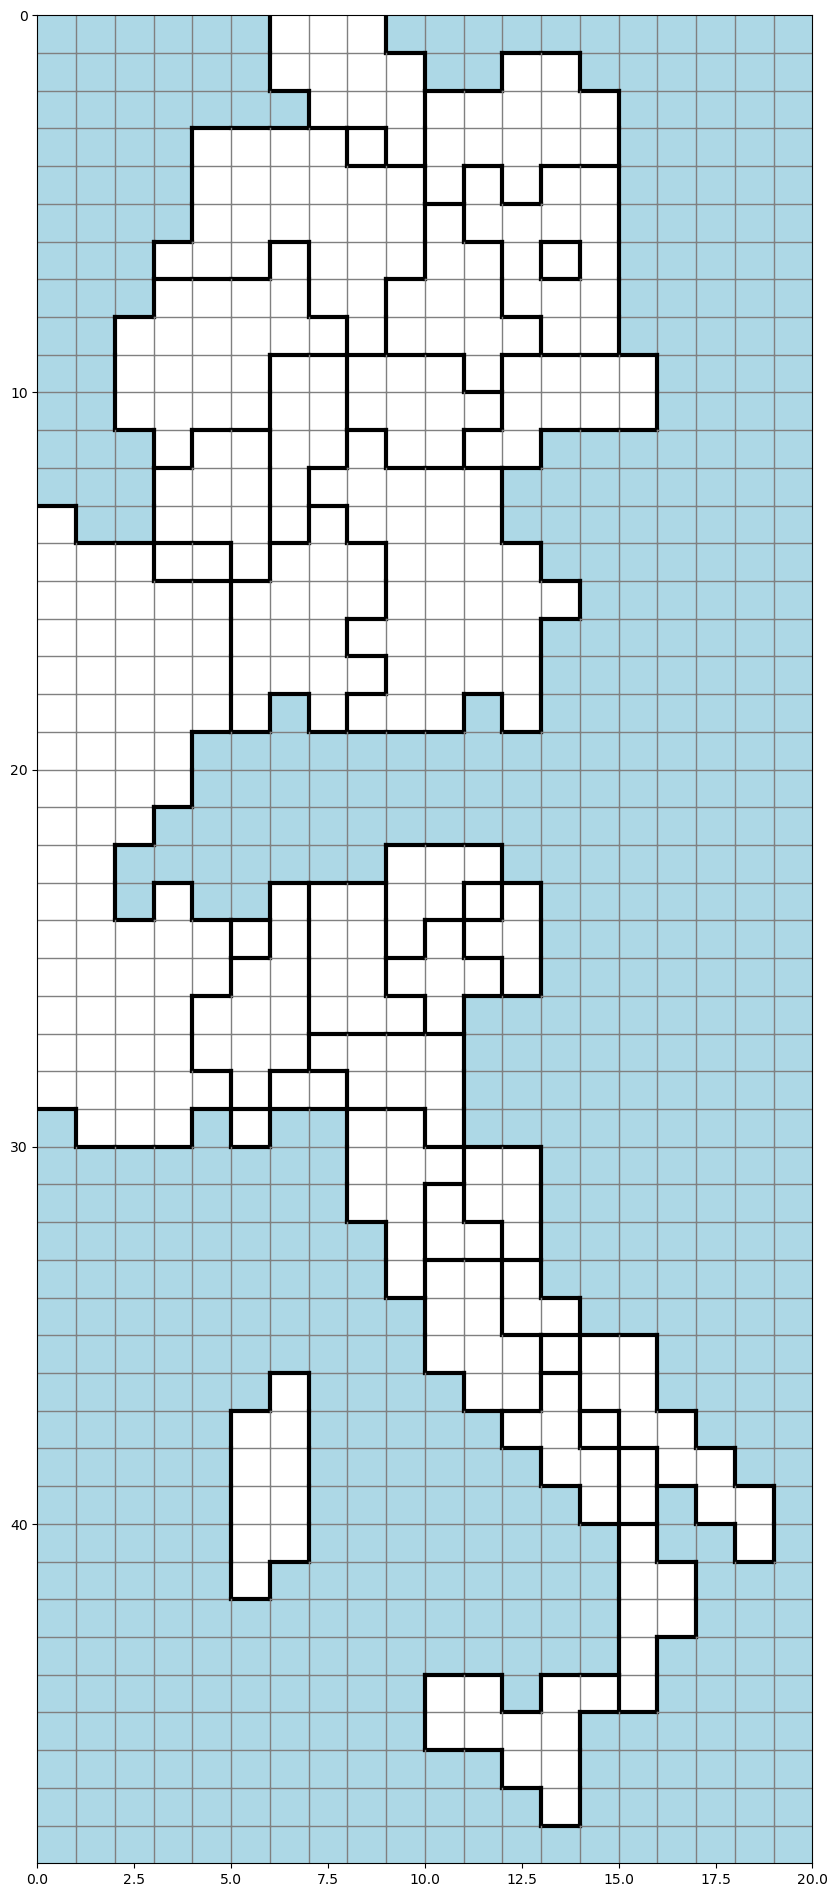

In [78]:
draw_map(grid,10,24)

In [79]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

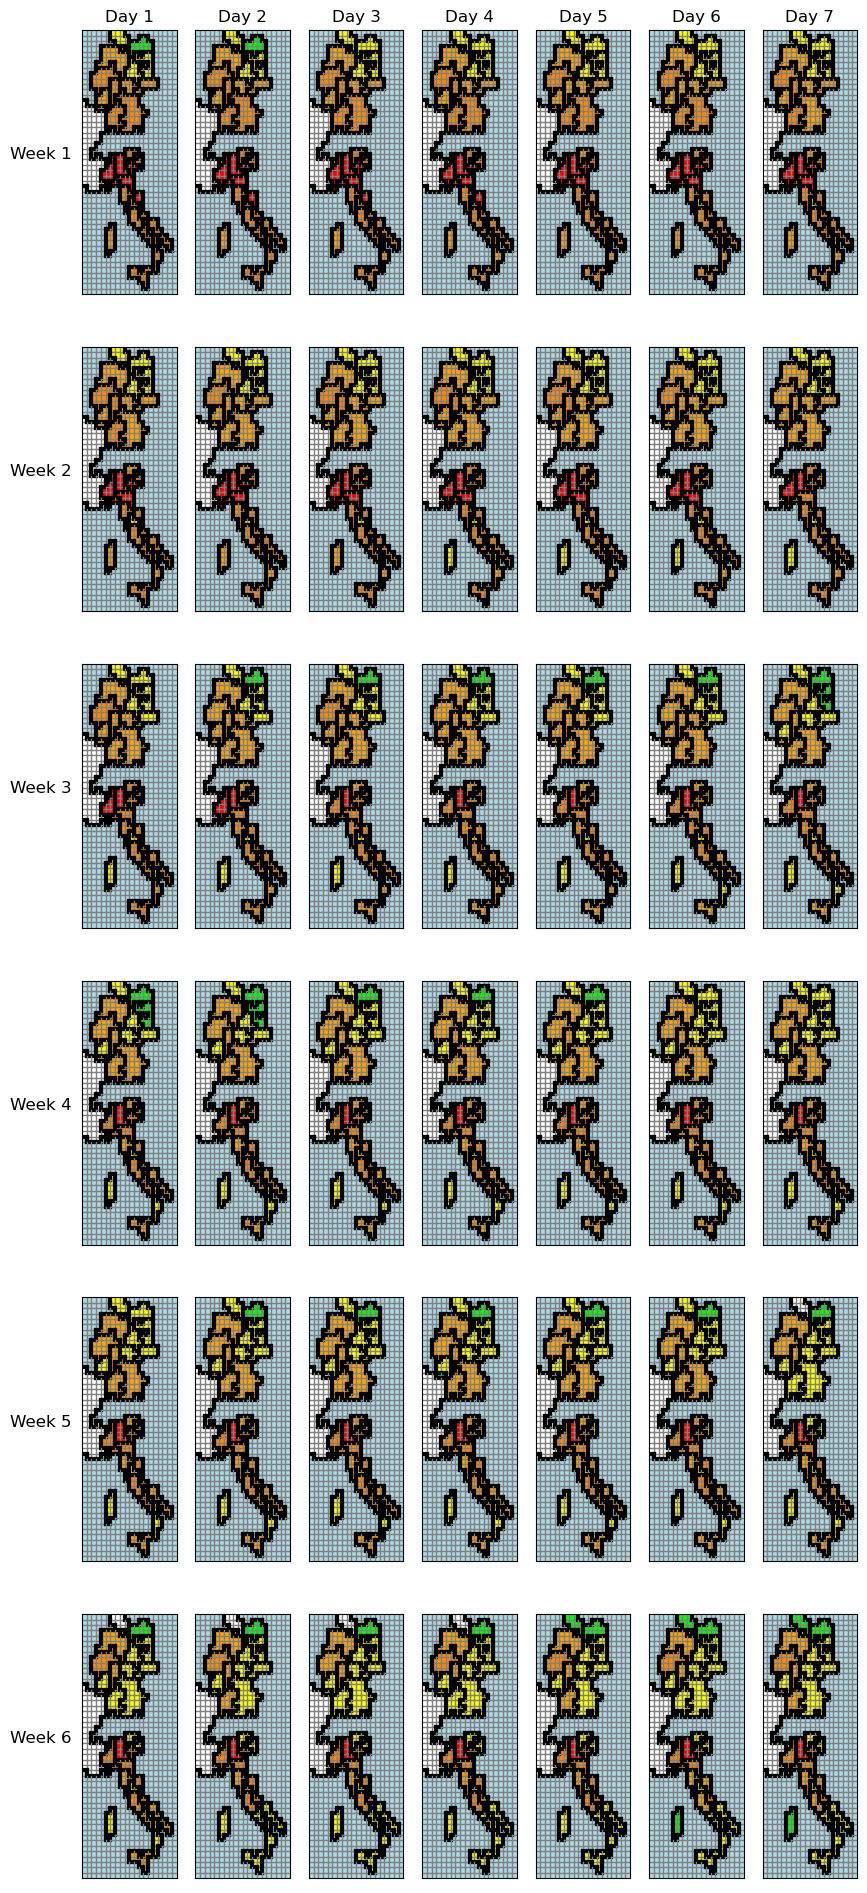

In [73]:
draw_color_map(grid,ca_infected,6,10,24)

In [80]:
q = find_q(delta_I, p)
indices=np.where(grid==36)
q[indices]=np.random.uniform(-0.01, 0.1, size=(len(indices[0]),6))

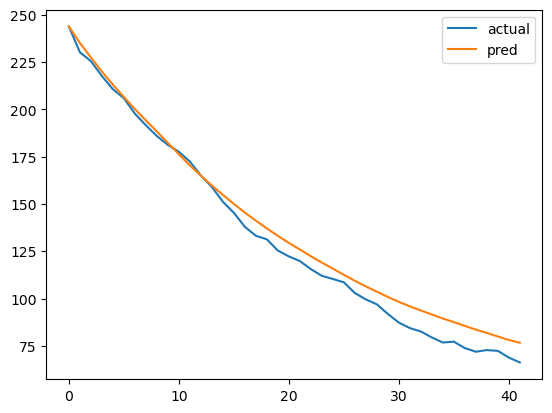

In [81]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

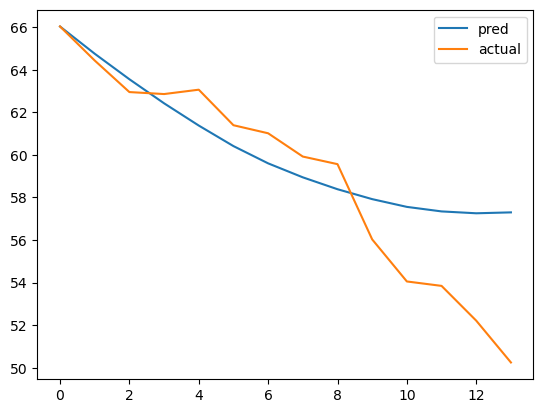

In [82]:
actual=calculate_ca(prediction_days,grid,test_infected)
m=actual[0]
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    p_bar=calculate_p_bar(m_bar)
    m=calculate_m(m_bar,p_bar,q)
prediction[-1]=calculate_m_bar(m) 
pred_sums=[prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums=[actual[i].sum()/total_cells for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

In [ ]:
draw_color_map(grid,actual,2,20,8)

In [ ]:
draw_color_map(grid,prediction,2,20,8)

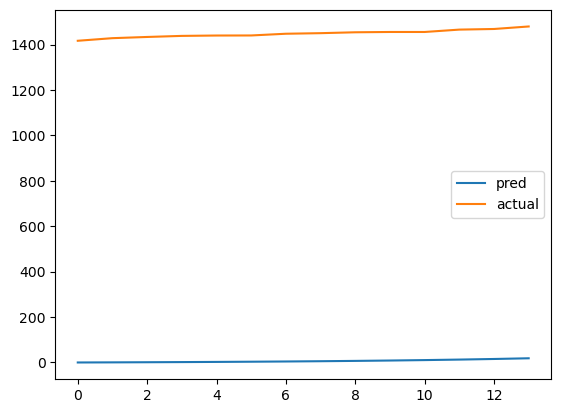

In [83]:
spread_actual=pd.read_csv('data/france/actual.csv', usecols=range(4+days+prediction_days))
fixed_columns = spread_actual.iloc[:, :4]
variable_columns = spread_actual.iloc[:, 4:]
spread_actual=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)

indices=np.where(grid==36)
pred_sums=[prediction[i,indices[0],indices[1]].sum()/66 for i in range(prediction_days)]
actual_sums=[spread_actual.values[0,4+i]/66 for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

# Austria

In [43]:
germany_grid = np.array([
    [0,0,0,0,14,14,14,0,0,0,0,0,0,0],
    [0,0,0,0,14,14,14,14,0,0,8,8,0,0],
    [0,0,0,0,0,14,14,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,6,14,8,8,8,8,8,0],
    [0,0,5,5,5,5,5,5,8,4,8,4,4,0],
    [0,0,5,5,5,5,5,5,13,4,4,4,4,0],
    [0,5,5,5,9,5,5,5,13,13,4,3,4,0],
    [0,9,9,9,9,5,5,13,13,13,4,4,4,0],
    [9,9,9,9,9,9,5,13,13,13,13,4,4,0],
    [9,9,9,9,7,7,15,15,15,13,12,12,12,12],
    [9,9,9,9,7,7,15,15,15,15,12,12,12,12],
    [0,9,10,10,7,7,2,15,15,12,12,0,0,0],
    [0,10,10,10,7,2,2,2,2,2,0,0,0,0],
    [0,10,10,10,7,1,2,2,2,2,0,0,0,0],
    [0,11,11,10,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,2,0,0],
    [0,0,0,1,1,1,2,2,2,2,2,0,0,0],
    [0,0,0,1,1,1,1,2,2,2,2,0,0,0],
    [0,0,0,1,0,1,2,2,2,0,2,0,0,0]
])

max_val=np.max(germany_grid)
italy_grid = np.array([
    [0,0,0,0,0,12,12,12,0,0,0,0,0,0,0],
    [0,0,13,9,9,12,12,20,6,0,0,0,0,0,0],
    [0,19,13,9,9,12,20,6,6,0,0,0,0,0,0],
    [0,13,13,9,9,20,20,20,6,0,0,0,0,0,0],
    [13,13,13,9,9,9,20,0,0,0,0,0,0,0,0],
    [13,13,13,5,5,5,5,0,0,0,0,0,0,0,0],
    [0,13,8,8,5,5,5,0,0,0,0,0,0,0,0],
    [0,8,0,0,17,17,5,0,0,0,0,0,0,0,0],
    [0,0,0,0,17,17,17,10,10,0,0,0,0,0,0],
    [0,0,0,0,17,17,18,10,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,18,18,10,0,0,0,0,0,0],
    [0,0,0,0,0,17,7,7,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,7,7,7,11,14,14,0,0,0],
    [0,0,15,0,0,0,0,7,7,4,14,14,0,0,0],
    [0,15,15,0,0,0,0,0,4,4,2,14,14,0,0],
    [0,15,15,0,0,0,0,0,0,4,4,2,14,14,0],
    [0,15,15,0,0,0,0,0,0,0,4,2,0,14,14],
    [0,15,15,0,0,0,0,0,0,0,0,3,0,0,14],
    [0,15,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,3,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,3,0,0,0],
    [0,0,0,0,0,0,16,16,0,16,16,3,0,0,0],
    [0,0,0,0,0,0,16,16,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,16,16,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,16,0,0,0,0,0]
])
italy_grid[italy_grid!=0]+=max_val

max_val=np.max(italy_grid)
austria_grid=np.array([
[0,0,0,0,1,1,1,1,1,1,1,1,1],
[0,0,1,0,1,1,1,1,1,1,1,1,0],
[1,1,1,1,1,1,1,1,1,1,1,0,0],
[1,1,1,1,1,1,1,1,1,1,1,0,0],
[0,0,1,1,1,1,1,1,1,1,1,0,0],
[0,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0]
])
austria_grid[austria_grid!=0]+=max_val


grid=np.zeros((germany_grid.shape[0]+italy_grid.shape[0]+4,italy_grid.shape[1]+austria_grid.shape[1]-8))
grid[:germany_grid.shape[0],:germany_grid.shape[1]]=germany_grid
grid[germany_grid.shape[0]-2:germany_grid.shape[0]+5,7:austria_grid.shape[1]+7]+=austria_grid
grid[germany_grid.shape[0]+4:germany_grid.shape[0]+italy_grid.shape[0]+4,1:italy_grid.shape[1]+1]+=italy_grid

days =6*7
prediction_days=2*7

final_df = pd.read_csv('data/austria/time_series_covid19_active_global.csv', usecols=range(4+days+prediction_days))

fixed_columns = final_df.iloc[:, :4]
variable_columns = final_df.iloc[:, 4:]

train_infected=pd.concat([fixed_columns, variable_columns.iloc[:, :(days)]], axis=1)
test_infected=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)
regions = pd.read_csv('data/austria/regions.csv')

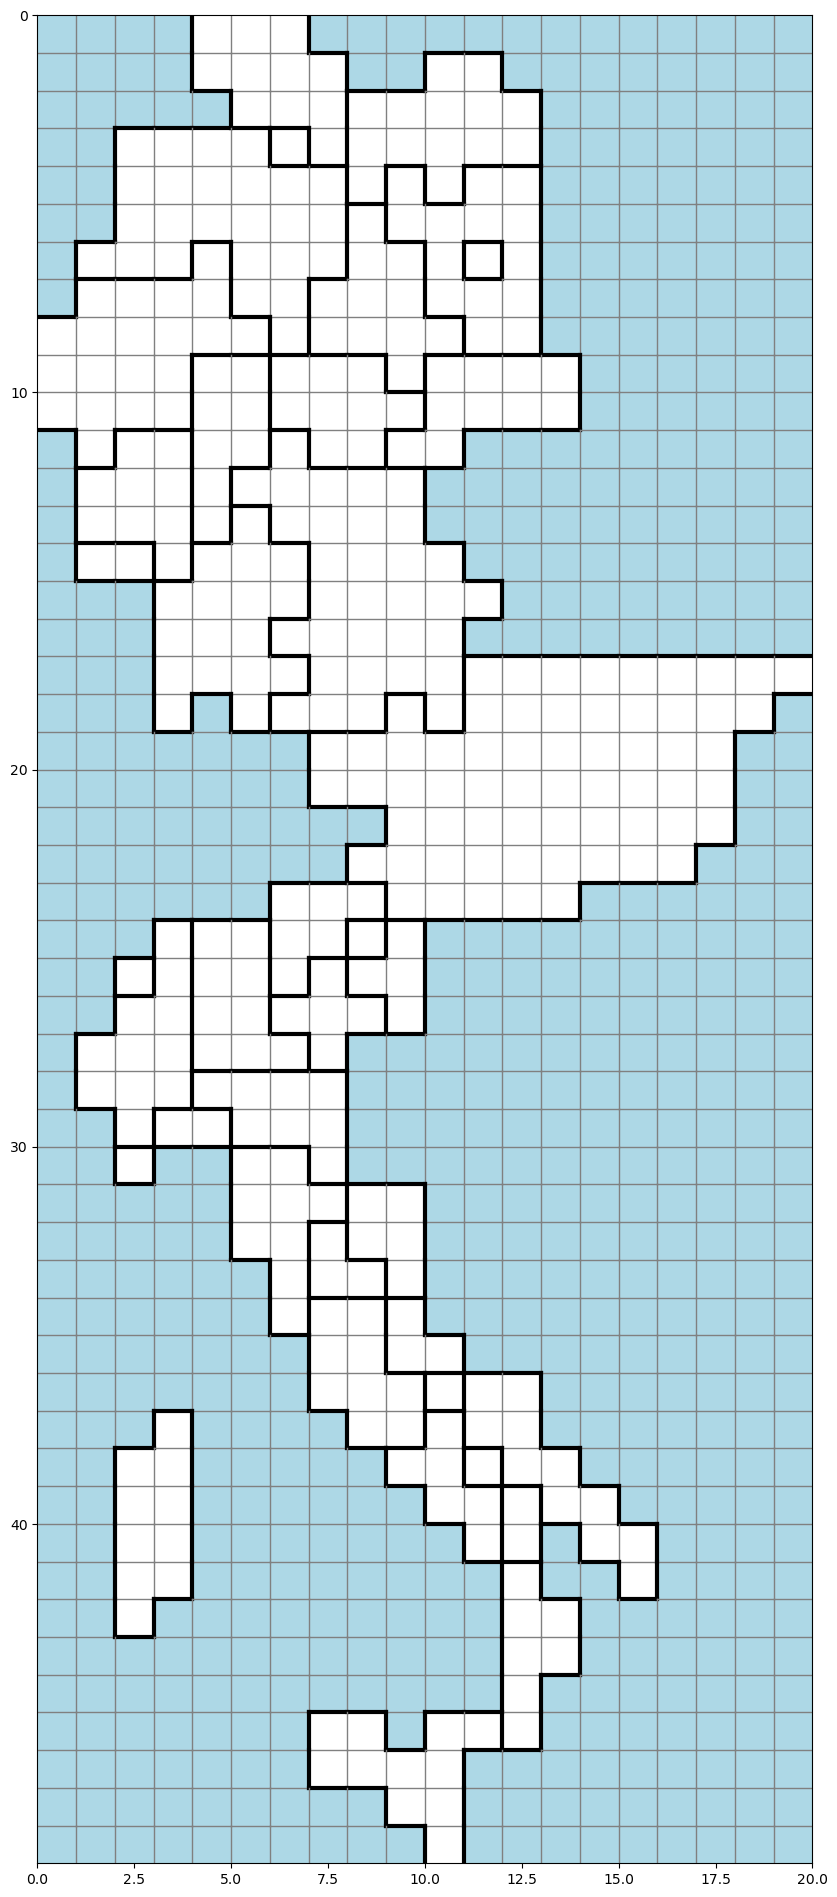

In [40]:
draw_map(grid,10,24)

In [44]:
ca_infected = calculate_ca(days,grid,train_infected)

delta_I = np.diff(ca_infected, axis=0)

p=calculate_p(ca_infected)

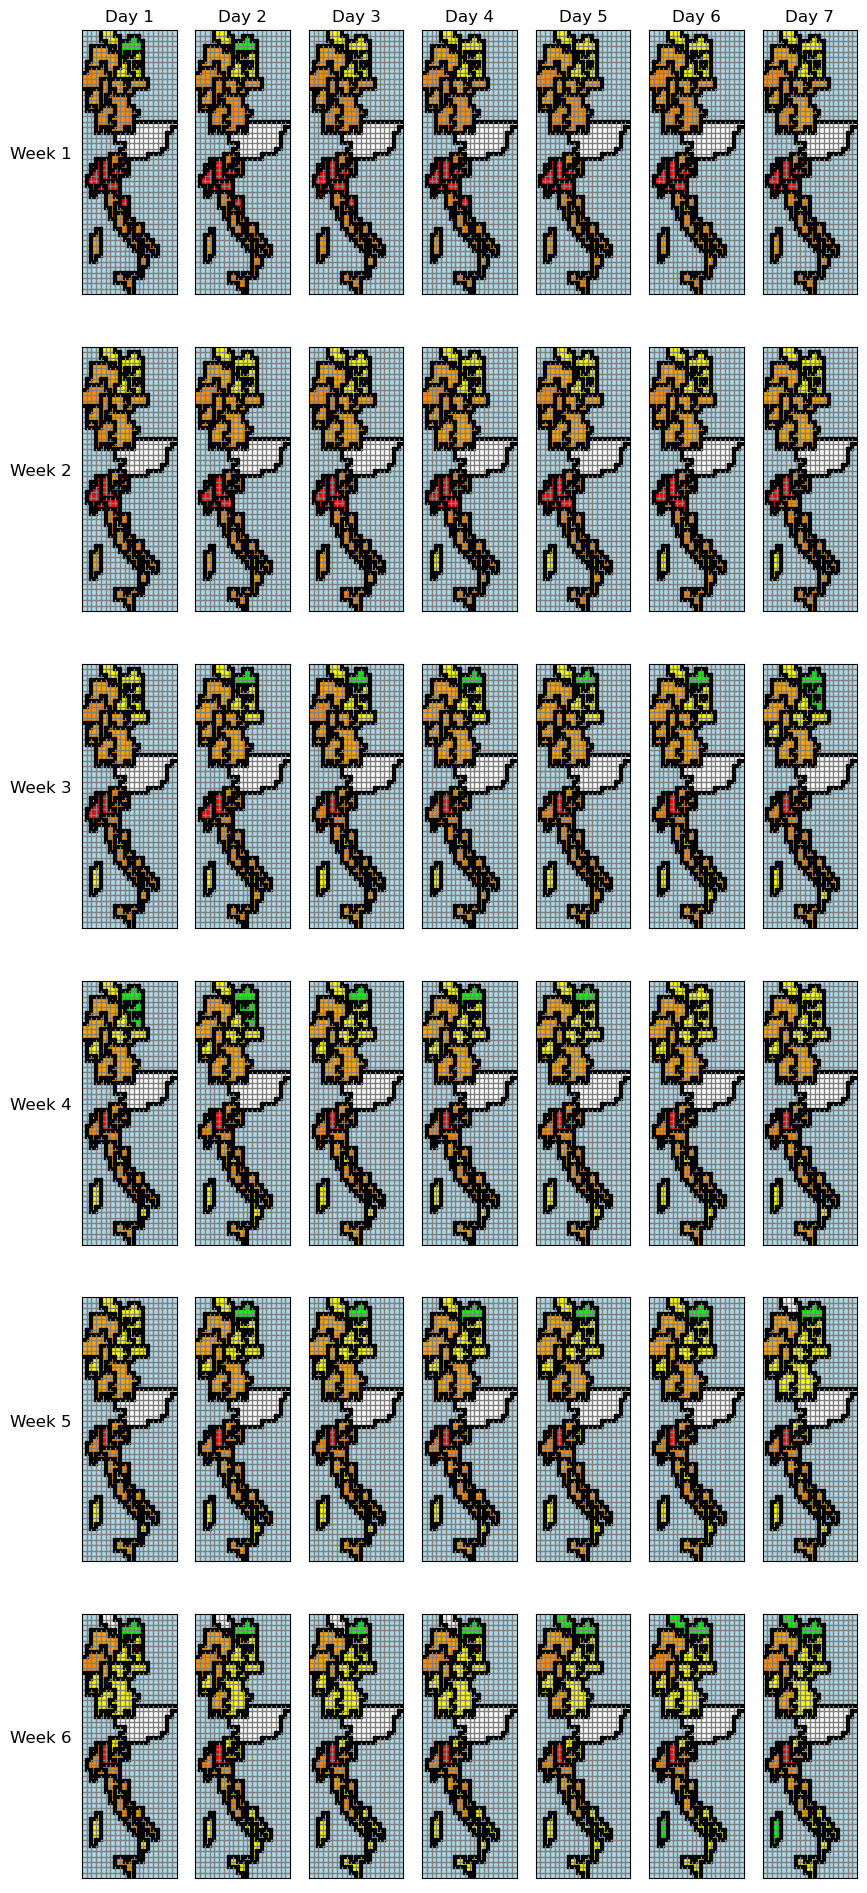

In [45]:
draw_color_map(grid,ca_infected,6,10,24)

In [73]:
q = find_q(delta_I, p)
indices=np.where(grid==36)
q[indices]=np.random.uniform(-0.01, 0.1, size=(len(indices[0]),6))

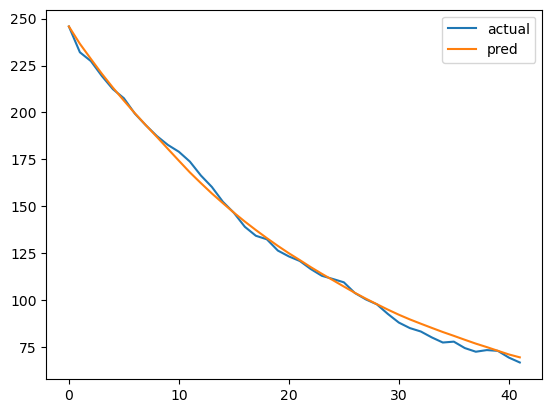

In [74]:
_,counts=np.unique(grid,return_counts=True)
total_cells=counts[1:].sum()
prediction=np.zeros((days,grid.shape[0],grid.shape[1]))
m=ca_infected[0]
for i in range(1,days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    m=calculate_m(m_bar,p[i-1],q)
prediction[-1]=calculate_m_bar(m) 
sums=[ca_infected[i].sum()/total_cells for i in range(days)]
pred_sums=[prediction[i].sum()/total_cells for i in range(days)]

plt.plot(range(days),sums,label="actual")
plt.plot(range(days),pred_sums,label="pred")
plt.legend()
plt.show()

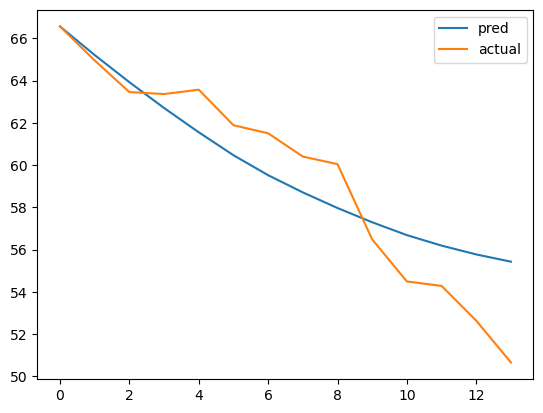

In [75]:
actual=calculate_ca(prediction_days,grid,test_infected)
m=actual[0]
prediction=np.zeros((prediction_days,grid.shape[0],grid.shape[1]))
for i in range(1,prediction_days):
    m_bar=calculate_m_bar(m)
    prediction[i-1]=m_bar
    p_bar=calculate_p_bar(m_bar)
    m=calculate_m(m_bar,p_bar,q)
prediction[-1]=calculate_m_bar(m) 
pred_sums=[prediction[i].sum()/total_cells for i in range(prediction_days)]
actual_sums=[actual[i].sum()/total_cells for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()

KeyboardInterrupt: 

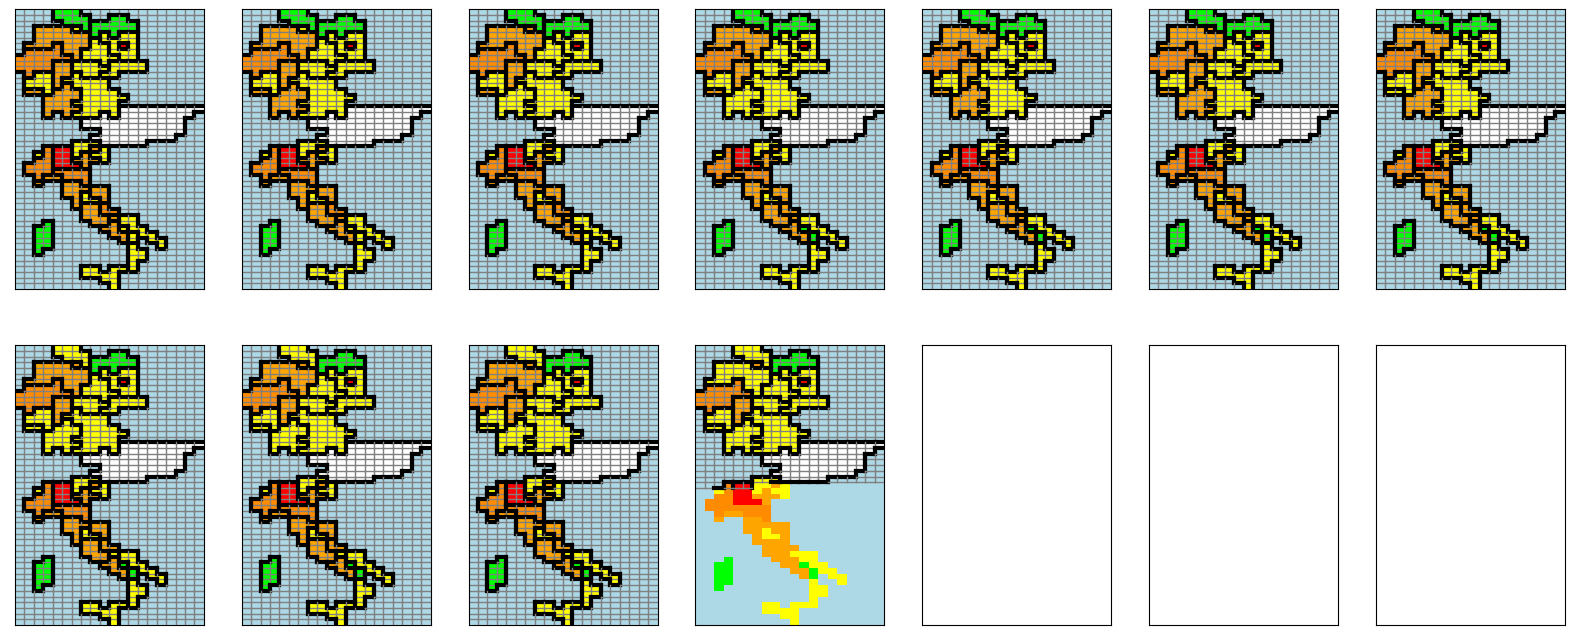

In [67]:
draw_color_map(grid,actual,2,20,8)

In [ ]:
draw_color_map(grid,prediction,2,20,8)

In [ ]:
spread_actual=pd.read_csv('data/switzerland/actual.csv', usecols=range(4+days+prediction_days))
fixed_columns = spread_actual.iloc[:, :4]
variable_columns = spread_actual.iloc[:, 4:]
spread_actual=pd.concat([fixed_columns, variable_columns.iloc[:, (days):]], axis=1)

indices=np.where(grid==36)
pred_sums=[prediction[i,indices[0],indices[1]].sum()/63 for i in range(prediction_days)]
actual_sums=[spread_actual.values[0,4+i]/63 for i in range(prediction_days)]
plt.plot(range(prediction_days),pred_sums,label="pred")
plt.plot(range(prediction_days),actual_sums,label="actual")
plt.legend()
plt.show()